In [ ]:

import sys
sys.path.insert(0, "/home/clu/SMAX")

import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
import smax
# from smax.wrappers.smaxbaselines import LogWrapper, ArrayInterfaceWrapper
import matplotlib.pyplot as plt


In [2]:
# !pip install overcooked-ai
# INSTALL FROM SOURCE INSTEAD

In [8]:
# all_results = {}
benchmark_nums = [1, 100, 10000]

In [4]:
# all_results = jnp.load("all_results.npy", allow_pickle=True).item()

In [5]:
all_results

{('MPE_simple_spread_v3', 1): 5475.70817059985,
 ('MPE_simple_spread_v3', 100): 523600.41700165527,
 ('MPE_simple_spread_v3', 10000): 39882784.655428834,
 ('MPE_simple_reference_v3', 1): 5240.872271494457,
 ('MPE_simple_reference_v3', 100): 485210.32589098165,
 ('MPE_simple_reference_v3', 10000): 33523302.28878871,
 ('og_simple_spread_v3', 1): 83407.43388772309,
 ('og_simple_reference_v3', 1): 145938.18992279287,
 ('switch_riddle', 1): 6243.557390195758,
 ('switch_riddle', 100): 792431.9138735549,
 ('switch_riddle', 10000): 66800233.28779072,
 ('og_switch', 1): 26936.75032835225,
 ('hanabi', 1): 1355.4449452840627,
 ('hanabi', 100): 104974.24049709352,
 ('hanabi', 10000): 5023814.470628057,
 ('og_hanabi', 1): 2095.026492374681,
 ('overcooked', 1): 3594.9621307947377,
 ('overcooked', 100): 304414.73419551074,
 ('overcooked', 10000): 16901516.363315463,
 ('og_overcooked', 1): 1913.2450620862085,
 ('ant_4x2', 1): 270.0114884137075,
 ('ant_4x2', 100): 18117.78938049626,
 ('ant_4x2', 10000)

# MPE

In [52]:

class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        return pi

def make_benchmark(config):
    env = smax.make(config["ENV_NAME"], **config["ENV_KWARGS"])
    env = ArrayInterfaceWrapper(env)
    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
    if config["ACTION_SELECTION"] == "nn":
        network = ActorCritic(
            env.action_space(env.agents[0]).n, activation=config["ACTIVATION"]
        )
    def benchmark(rng):
        def init_runner_state(rng):
            # INIT NETWORK
            # network = ActorCritic(
            #     env.action_space(env.agents[0]).n, activation=config["ACTIVATION"]
            # )
            if config["ACTION_SELECTION"] == "nn":
                rng, _rng = jax.random.split(rng)
                init_x = jnp.zeros(env.observation_space(env.agents[0]).shape)
                params = network.init(_rng, init_x)
            else:
                params = None
            # INIT ENV
            rng, _rng = jax.random.split(rng)
            reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state = jax.vmap(env.reset)(reset_rng)

            return (params, env_state, obsv, rng)

        def env_step(runner_state, unused):
            params, env_state, last_obs, rng = runner_state

            # SELECT ACTION
            rng, _rng = jax.random.split(rng)

            # obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])

            if config["ACTION_SELECTION"] == "nn":
                pi, _ = network.apply(params, last_obs)
                action = pi.sample(seed=_rng)

            elif config["ACTION_SELECTION"] == "random":
                rngs = jax.random.split(_rng, config["NUM_ACTORS"])
                action = jax.vmap(env.action_space().sample)(rngs)
                action = action.reshape((config["NUM_ENVS"], env.num_agents, -1))
            else:
                raise ValueError("ACTION_SELECTION must be 'random' or 'nn'")

            # STEP ENV
            rng, _rng = jax.random.split(rng)
            rng_step = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state, _, _, info = jax.vmap(env.step)(
                rng_step, env_state, action
            )
            runner_state = (params, env_state, obsv, rng)
            return runner_state, None

        rng, init_rng = jax.random.split(rng)
        runner_state = init_runner_state(init_rng)
        # num_steps = config["TOTAL_STEPS"] / config["NUM_ENVS"] # Q: ACTOR STEPS? OR ENV STEPS?
        num_steps = config["NUM_STEPS"]
        runner_state = jax.lax.scan(env_step, runner_state, None, num_steps)
        return runner_state

    return benchmark


In [4]:
import time
config = {
    "NUM_STEPS": 1000,
    "NUM_ENVS": 10000,
    "ACTIVATION": "relu",
    "ENV_KWARGS": {},
    "ENV_NAME": "MPE_simple_spread_v3",
    "NUM_SEEDS": 1,
    "SEED": 0,
    "ACTION_SELECTION": "random"
}

benchmark_fn = jax.jit(make_benchmark(config))
rng = jax.random.PRNGKey(config["SEED"])
rng, _rng = jax.random.split(rng)
benchmark_jit = jax.jit(benchmark_fn).lower(_rng).compile()
before = time.perf_counter_ns()
runner_state = jax.block_until_ready(benchmark_jit(_rng))
after = time.perf_counter_ns()
total_time = (after - before) / 1e9
print(f"Total Time (s): {total_time}")
print(f"Total Steps: {config['NUM_STEPS'] * config['NUM_ENVS']}")
print(f"SPS: {config['NUM_STEPS'] * config['NUM_ENVS'] / total_time}")


/usr/local/lib/python3.8/dist-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Total Time (s): 0.257316251
Total Steps: 10000000
SPS: 38862683.41442609


In [5]:
import time
config = {
    "NUM_STEPS": 1000,
    "NUM_ENVS": 10000,
    "ACTIVATION": "relu",
    "ENV_KWARGS": {},
    "ENV_NAME": "MPE_simple_reference_v3",
    "NUM_SEEDS": 1,
    "SEED": 0,
    "ACTION_SELECTION": "random"
}

benchmark_fn = jax.jit(make_benchmark(config))
rng = jax.random.PRNGKey(config["SEED"])
rng, _rng = jax.random.split(rng)
benchmark_jit = jax.jit(benchmark_fn).lower(_rng).compile()
before = time.perf_counter_ns()
runner_state = jax.block_until_ready(benchmark_jit(_rng))
after = time.perf_counter_ns()
total_time = (after - before) / 1e9
print(f"Total Time (s): {total_time}")
print(f"Total Steps: {config['NUM_STEPS'] * config['NUM_ENVS']}")
print(f"SPS: {config['NUM_STEPS'] * config['NUM_ENVS'] / total_time}")


/usr/local/lib/python3.8/dist-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Total Time (s): 0.27817452
Total Steps: 10000000
SPS: 35948655.54185193


In [6]:
import time

speed_simple_spread = []
for env in ["MPE_simple_spread_v3", "MPE_simple_reference_v3"]:
    print("*"*10)
    print(f"Env: {env}")
    for num_envs in benchmark_nums:
        config = {
            "NUM_STEPS": 1000,
            "NUM_ENVS": num_envs,
            "ACTIVATION": "relu",
            "ENV_KWARGS": {},
            "ENV_NAME": env,
            "NUM_SEEDS": 1,
            "SEED": 0,
            "ACTION_SELECTION": "random"
        }

        benchmark_fn = jax.jit(make_benchmark(config))
        rng = jax.random.PRNGKey(config["SEED"])
        rng, _rng = jax.random.split(rng)
        benchmark_jit = jax.jit(benchmark_fn).lower(_rng).compile()
        before = time.perf_counter_ns()
        runner_state = jax.block_until_ready(benchmark_jit(_rng))
        after = time.perf_counter_ns()
        total_time = (after - before) / 1e9
        print(f"Num Envs: {num_envs}")
        print(f"Total Time (s): {total_time}")
        print(f"Total Steps: {config['NUM_STEPS'] * config['NUM_ENVS']}")
        print(f"SPS: {config['NUM_STEPS'] * config['NUM_ENVS'] / total_time}")
        if env == "MPE_simple_spread_v3":
            speed_simple_spread.append(total_time)
        all_results[(config["ENV_NAME"], num_envs)] = config['NUM_STEPS'] * config['NUM_ENVS'] / total_time


**********
Env: MPE_simple_spread_v3


/usr/local/lib/python3.8/dist-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Num Envs: 1
Total Time (s): 0.18262478
Total Steps: 1000
SPS: 5475.70817059985
Num Envs: 100
Total Time (s): 0.190985333
Total Steps: 100000
SPS: 523600.41700165527
Num Envs: 10000
Total Time (s): 0.250734749
Total Steps: 10000000
SPS: 39882784.655428834
**********
Env: MPE_simple_reference_v3
Num Envs: 1
Total Time (s): 0.190807932
Total Steps: 1000
SPS: 5240.872271494457
Num Envs: 100
Total Time (s): 0.206096191
Total Steps: 100000
SPS: 485210.32589098165
Num Envs: 10000
Total Time (s): 0.298299968
Total Steps: 10000000
SPS: 33523302.28878871


In [9]:

import time
from pettingzoo.mpe import simple_spread_v3
env = simple_spread_v3.parallel_env()
before = time.perf_counter_ns()
observations, infos = env.reset()

for i in range(1000):
    # this is where you would insert your policy
    actions = {agent: env.action_space(agent).sample() for agent in env.agents}
    observations, rewards, terminations, truncations, infos = env.step(actions)
after = time.perf_counter_ns()
total_time = (after - before) / 1e9
print(f"Total Time (s): {total_time}")
print(f"SPS: {1000 / total_time}")
all_results[("og_simple_spread_v3", 1)] = 1000 / total_time


Total Time (s): 0.011989339
SPS: 83407.43388772309


In [15]:

import time
from pettingzoo.mpe import simple_spread_v3
env = simple_spread_v3.parallel_env()
observations, infos = env.reset()

In [21]:
env.action_space(env.agents[0])

Discrete(5)

In [17]:
infos

{'agent_0': {}, 'agent_1': {}, 'agent_2': {}}

In [10]:

import time
from pettingzoo.mpe import simple_reference_v3
env = simple_reference_v3.parallel_env()
before = time.perf_counter_ns()
observations, infos = env.reset()

for i in range(1000):
    # this is where you would insert your policy
    actions = {agent: env.action_space(agent).sample() for agent in env.agents}
    observations, rewards, terminations, truncations, infos = env.step(actions)
after = time.perf_counter_ns()
total_time = (after - before) / 1e9
print(f"Total Time (s): {total_time}")
print(f"SPS: {1000 / total_time}")
all_results[("og_simple_reference_v3", 1)] = 1000 / total_time


Total Time (s): 0.006852216
SPS: 145938.18992279287


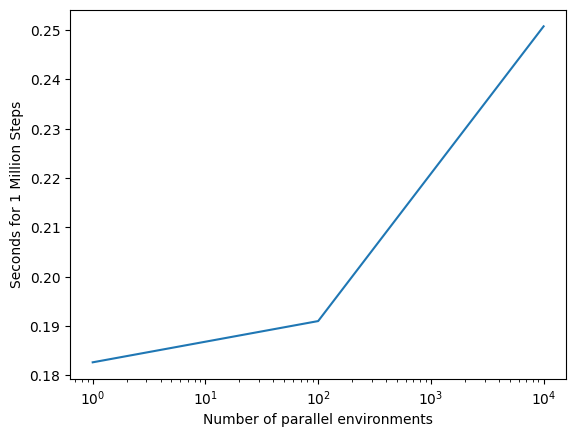

In [11]:

import matplotlib.pyplot as plt

plt.plot(benchmark_nums, speed_simple_spread)
plt.ylabel("Seconds for 1 Million Steps")
plt.xscale('log')
plt.xlabel("Number of parallel environments")
plt.show()

In [13]:
jnp.save("all_results.npy", all_results)

In [12]:
all_results

{('MPE_simple_spread_v3', 1): 5475.70817059985,
 ('MPE_simple_spread_v3', 100): 523600.41700165527,
 ('MPE_simple_spread_v3', 10000): 39882784.655428834,
 ('MPE_simple_reference_v3', 1): 5240.872271494457,
 ('MPE_simple_reference_v3', 100): 485210.32589098165,
 ('MPE_simple_reference_v3', 10000): 33523302.28878871,
 ('og_simple_spread_v3', 1): 83407.43388772309,
 ('og_simple_reference_v3', 1): 145938.18992279287}

# SWITCH

In [15]:
class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        return pi

def make_benchmark(config):
    env = smax.make(config["ENV_NAME"], **config["ENV_KWARGS"])
    # env = ArrayInterfaceWrapper(env)
    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
    if config["ACTION_SELECTION"] == "nn":
        network = ActorCritic(
            env.action_space(env.agents[0]).n, activation=config["ACTIVATION"]
        )
    def benchmark(rng):
        def init_runner_state(rng):
            # INIT NETWORK
            # network = ActorCritic(
            #     env.action_space(env.agents[0]).n, activation=config["ACTIVATION"]
            # )
            if config["ACTION_SELECTION"] == "nn":
                rng, _rng = jax.random.split(rng)
                init_x = jnp.zeros(env.observation_space(env.agents[0]).shape)
                params = network.init(_rng, init_x)
            else:
                params = None

            # INIT ENV
            rng, _rng = jax.random.split(rng)
            reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state = jax.vmap(env.reset)(reset_rng)

            return (params, env_state, obsv, rng)

        def env_step(runner_state, unused):
            params, env_state, last_obs, rng = runner_state

            # SELECT ACTION
            rng, _rng = jax.random.split(rng)

            if config["ACTION_SELECTION"] == "nn":
                pi, _ = network.apply(params, last_obs)
                action = pi.sample(seed=_rng)

            elif config["ACTION_SELECTION"] == "random":
                rngs = jax.random.split(_rng, config["NUM_ACTORS"]).reshape((env.num_agents, config["NUM_ENVS"], -1))
                actions = {k: jax.vmap(env.action_space(k).sample)(rngs[i]) for i, k in enumerate(env.agents)}
            else:
                raise ValueError("ACTION_SELECTION must be 'random' or 'nn'")

            # STEP ENV
            rng, _rng = jax.random.split(rng)
            rng_step = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state, _, _, info = jax.vmap(env.step)(
                rng_step, env_state, actions
            )
            runner_state = (params, env_state, obsv, rng)
            return runner_state, None

        rng, init_rng = jax.random.split(rng)
        runner_state = init_runner_state(init_rng)
        runner_state = jax.lax.scan(env_step, runner_state, None, config["NUM_STEPS"])
        return runner_state

    return benchmark


In [17]:

import time
config = {
    "NUM_STEPS": 1000,
    "NUM_ENVS": 10000,
    "ACTIVATION": "relu",
    "ENV_KWARGS": {},
    "ENV_NAME": "switch_riddle",
    "NUM_SEEDS": 1,
    "SEED": 0,
    "ACTION_SELECTION": "random"
}

benchmark_fn = jax.jit(make_benchmark(config))
rng = jax.random.PRNGKey(config["SEED"])
rng, _rng = jax.random.split(rng)
benchmark_jit = jax.jit(benchmark_fn).lower(_rng).compile()
before = time.perf_counter_ns()
runner_state = jax.block_until_ready(benchmark_jit(_rng))
after = time.perf_counter_ns()
total_time = (after - before) / 1e9

print(f"Total Time (s): {total_time}")
print(f"Total Steps: {config['NUM_STEPS'] * config['NUM_ENVS']}")
print(f"SPS: {config['NUM_STEPS'] * config['NUM_ENVS'] / total_time}")
# all_results[(config["ENV_NAME"], num_envs)] = config['NUM_STEPS'] * config['NUM_ENVS'] / total_time


Total Time (s): 0.182114387
Total Steps: 10000000
SPS: 54910543.668359384


In [19]:
import time

for num_envs in benchmark_nums:
    config = {
        "NUM_STEPS": 1000,
        "NUM_ENVS": num_envs,
        "ACTIVATION": "relu",
        "ENV_KWARGS": {},
        "ENV_NAME": "switch_riddle",
        "NUM_SEEDS": 1,
        "SEED": 0,
        "ACTION_SELECTION": "random"
    }

    benchmark_fn = jax.jit(make_benchmark(config))
    rng = jax.random.PRNGKey(config["SEED"])
    rng, _rng = jax.random.split(rng)
    benchmark_jit = jax.jit(benchmark_fn).lower(_rng).compile()
    before = time.perf_counter_ns()
    runner_state = jax.block_until_ready(benchmark_jit(_rng))
    after = time.perf_counter_ns()
    total_time = (after - before) / 1e9
    print(f"Total Time (s): {total_time}")
    print(f"Total Steps: {config['NUM_STEPS'] * config['NUM_ENVS']}")
    print(f"SPS: {config['NUM_STEPS'] * config['NUM_ENVS'] / total_time}")
    all_results[(config["ENV_NAME"], num_envs)] = config['NUM_STEPS'] * config['NUM_ENVS'] / total_time

Total Time (s): 0.160165101
Total Steps: 1000
SPS: 6243.557390195758
Total Time (s): 0.126193807
Total Steps: 100000
SPS: 792431.9138735549
Total Time (s): 0.149700076
Total Steps: 10000000
SPS: 66800233.28779072


In [20]:
import numpy as np
import copy
from gym import spaces

# generalizing to any number of agents
class SwitchGame:
    def __init__(self, n_agents=3, include_actions=True):
        '''
        Initializes the Switch Game with given parameters.
        '''

        # Set game defaults
        self.n_agents = n_agents
        self.episode_limit = 4 * self.n_agents - 6
        self.reward_all_live = 1
        self.reward_all_die = -1

        self.reset()

        self.games = 0
        self.win = 0
        self.loose = 0
        self.draw = 0

        self.mf = True
        self.include_actions = include_actions
        self.max_reward = 1

    def refresh_game_tally(self):
        self.games = 0
        self.win = 0
        self.loose = 0
        self.draw = 0

    def reset(self):
        """
        Resets the environment for the next episode and sets up the agent sequence for the next episode.
        """
        self.cur_step = 0
        self.has_been = np.zeros(self.n_agents)
        self.active_agent = np.zeros(self.episode_limit+1) # collects one more after episode terminated
        self.last_action = np.zeros((self.n_agents, 4)).flatten()
        self.max_reward = 1

        self.switch = 0

        # (n_agents*2+1) 0: switch on/off, 1-3: in room agent ID, 4-6: if each agent has been in room
        self.state = np.zeros((self.n_agents * 2 + 1))

        # (n_agents, 3) 0: in room/None, 1: switch on, 2: switch off
        self.obs = [np.zeros(3) for _ in range(self.n_agents)]

        # determine which agent goes into room at each step
        for step in range(self.episode_limit+1):
            agent_id = np.random.randint(self.n_agents)
            self.active_agent[step] = agent_id

        # see whether all agents can go into the room to determine max reward
        tmp = len(np.unique(np.array(self.active_agent[:self.episode_limit])).tolist()) # off by one error
        if tmp < self.n_agents:
            self.max_reward = 0
        else:
            self.max_reward = 1

        # update state: switch is off, who is the first in room, the first one to have been in room
        self.state[int(self.active_agent[0]+1)] = 1
        # self.state[int(self.active_agent[0]+4)] = 1  # don't update this now, has_been at timestep t depends on active agent at timestpe t-1
        self.has_been[int(self.active_agent[0])] = 1

        # update obs: who is first to be in room, and who can see the switch is off
        self.obs[int(self.active_agent[0])][0] = 1 # update in room
        self.obs[int(self.active_agent[0])][2] = 1 # switch is off
        return self.obs


    def get_obs(self):
        return [self.obs[i].flatten() for i in range(self.n_agents)]

    def get_state(self):
        if not self.include_actions:
            return self.state.astype(np.float32)
        state = self.state

        if torch.is_tensor(state):
            state = state.cpu().data.numpy().astype(np.float32)
        actions = self.last_action
        if torch.is_tensor(actions):
            actions = actions.cpu().data.numpy().astype(np.float32)

        state = np.concatenate((state, actions), axis=0)
        return state

    def get_obs_size(self):
        return 3

    def get_state_size(self):
        if not self.include_actions:
            return 2 * self.n_agents + 1
        return 2 * self.n_agents + 1 + 4 * self.n_agents

    def get_avail_actions(self):
        '''
        :return:(n_agents,4)
        '''
        avail = np.zeros((self.n_agents, 4))
        active_agent_idx = int(self.active_agent[self.cur_step])
        for i in range(self.n_agents):
            if i == active_agent_idx:
                avail[i] = np.ones((4))
            else:
                avail[i] = np.array([0, 0, 0, 1])

        # check if no actions available (this should never happen though)
        for i in range(self.n_agents):
            if np.array(avail[i]).sum() == 0:
                raise ValueError("no actions available in switch mf env")
                avail[i] = [1]*4
        avail = avail.astype(int)
        return [avail[i].tolist() for i in range(self.n_agents)]

    def get_avail_agent_actions(self, agent_id):
        return self.get_avail_actions()[agent_id]

    def get_total_actions(self):
        # on, off, tell, none
        return 4

    def agents(self):
        return list(range(self.n_agents))
    
    def action_space(self, agent_id):
        return spaces.Discrete(4)

    def get_reward(self, a_t_idx, active_agent_idx):
        """
        Returns the reward for action a_t taken by current agent in state a_t
        """
        if a_t_idx == 2:  # if the active agent TELL
            terminal = True
            # check if all agent has been in the room
            tmp = copy.deepcopy(self.has_been)
            tmp[active_agent_idx] = 1 # set this to 1 because has_been does not account for timestep t

            # all agents visited room
            if np.sum(tmp) == self.n_agents:
                reward = self.reward_all_live
                self.win += 1
                self.games += 1
            else:
                reward = self.reward_all_die
                self.loose += 1
                self.games += 1

        elif self.cur_step >= self.episode_limit-1:  # if it didn't tell, but episode ended
            terminal = True
            reward = 0
            self.draw += 1
            self.games += 1

        else:  # episode did not end
            terminal = False
            reward = 0


        return reward, terminal

    def step(self, a_t_indices):
        '''
        :param a_t_indices: (n_agents)
        :return:
        '''
        # start from cur_step=0
        active_agent_idx = int(self.active_agent[self.cur_step])

        # only the active agent's action matters
        a_t_idx = a_t_indices[active_agent_idx]

        # update light switch
        if a_t_idx == 0:
            self.switch = 1
        elif a_t_idx == 1:
            self.switch = 0

        # get reward and term
        reward, terminal = self.get_reward(a_t_idx, active_agent_idx)

        # update last_action in one hot form (n_agents, 4):
        # self.last_action = F.one_hot(torch.tensor(a_t_indices, dtype=int).flatten(), num_classes=4).flatten().float()

        # update step counter
        self.cur_step += 1

        # Don't return yet update the obs to put into the bufer
        # if terminal:
        #     return reward, terminal, {}

        # update state obs for next timestep if its not the end
        active_agent_idx_prev = active_agent_idx
        active_agent_idx = int(self.active_agent[self.cur_step])

        # update state for next timestep
        switch = np.array([int(self.switch)])
        in_room = np.zeros((self.n_agents))
        in_room[active_agent_idx] = 1
        self.has_been[active_agent_idx_prev] = 1
        self.state = np.concatenate((switch, in_room, copy.deepcopy(self.has_been)), axis=0)

        # update observation
        for i in range(self.n_agents):
            if i == active_agent_idx:
                if switch == 0:
                    self.obs[i] = np.array([1, 0, 1])
                else:
                    self.obs[i] = np.array([1, 1, 0])
            else:
                self.obs[i] = np.zeros(3)

        return self.obs, reward, terminal, {} # leave info empty for now


    def render(self):
        return None

    def close(self):
        self.reset()
        return None

    def seed(self):
        return None

    def save_replay(self):
        return None

    def get_stats(self):
        stats = {}
        return stats

    def get_env_info(self):
        env_info = {"state_shape": self.get_state_size(),
                    "obs_shape": self.get_obs_size(),
                    "n_actions": self.get_total_actions(),
                    "n_agents": self.n_agents,
                    "episode_limit": self.episode_limit}
        return env_info

In [21]:

env = SwitchGame()
before = time.perf_counter_ns()
observations = env.reset()

terminated = False
for i in range(1000):
    if terminated:
        observations = env.reset()
    else:
        actions = {agent: env.action_space(agent).sample() for agent in env.agents()}
        observations, rewards, terminated, infos = env.step(actions)
after = time.perf_counter_ns()
total_time = (after - before) / 1e9
print(f"Total Time (s): {total_time}")
print(f"SPS: {1000 / total_time}")
all_results[("og_switch", 1)] = 1000 / total_time

Total Time (s): 0.037124003
SPS: 26936.75032835225


In [22]:
all_results

{('MPE_simple_spread_v3', 1): 5475.70817059985,
 ('MPE_simple_spread_v3', 100): 523600.41700165527,
 ('MPE_simple_spread_v3', 10000): 39882784.655428834,
 ('MPE_simple_reference_v3', 1): 5240.872271494457,
 ('MPE_simple_reference_v3', 100): 485210.32589098165,
 ('MPE_simple_reference_v3', 10000): 33523302.28878871,
 ('og_simple_spread_v3', 1): 83407.43388772309,
 ('og_simple_reference_v3', 1): 145938.18992279287,
 ('switch_riddle', 1): 6243.557390195758,
 ('switch_riddle', 100): 792431.9138735549,
 ('switch_riddle', 10000): 66800233.28779072,
 ('og_switch', 1): 26936.75032835225}

In [23]:
jnp.save("all_results.npy", all_results)

# HANABI

In [26]:

class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        return pi

def make_benchmark(config):
    env = smax.make(config["ENV_NAME"], **config["ENV_KWARGS"])
    # env = ArrayInterfaceWrapper(env)
    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
    if config["ACTION_SELECTION"] == "nn":
        network = ActorCritic(
            env.action_space(env.agents[0]).n, activation=config["ACTIVATION"]
        )
    def benchmark(rng):
        def init_runner_state(rng):
            # INIT NETWORK
            # network = ActorCritic(
            #     env.action_space(env.agents[0]).n, activation=config["ACTIVATION"]
            # )
            if config["ACTION_SELECTION"] == "nn":
                rng, _rng = jax.random.split(rng)
                init_x = jnp.zeros(env.observation_space(env.agents[0]).shape)
                params = network.init(_rng, init_x)
            else:
                params = None

            # INIT ENV
            rng, _rng = jax.random.split(rng)
            reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state = jax.vmap(env.reset)(reset_rng)

            return (params, env_state, obsv, rng)

        def env_step(runner_state, unused):
            params, env_state, last_obs, rng = runner_state

            # SELECT ACTION
            rng, _rng = jax.random.split(rng)

            if config["ACTION_SELECTION"] == "nn":
                pi, _ = network.apply(params, last_obs)
                actions = pi.sample(seed=_rng)

            elif config["ACTION_SELECTION"] == "random":
                rngs = jax.random.split(_rng, config["NUM_ACTORS"]).reshape((env.num_agents, config["NUM_ENVS"], -1))
                actions = {k: jax.vmap(env.action_space(k).sample)(rngs[i]) for i, k in enumerate(env.agents)}
            else:
                raise ValueError("ACTION_SELECTION must be 'random' or 'nn'")

            # STEP ENV
            rng, _rng = jax.random.split(rng)
            rng_step = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state, _, _, info = jax.vmap(env.step)(
                rng_step, env_state, actions
            )
            runner_state = (params, env_state, obsv, rng)
            return runner_state, None

        rng, init_rng = jax.random.split(rng)
        runner_state = init_runner_state(init_rng)
        runner_state = jax.lax.scan(env_step, runner_state, None, config["NUM_STEPS"])
        return runner_state

    return benchmark


In [27]:

import time
config = {
    "NUM_STEPS": 1000,
    "NUM_ENVS": 10000,
    "ACTIVATION": "relu",
    "ENV_KWARGS": {},
    "ENV_NAME": "hanabi",
    "NUM_SEEDS": 1,
    "SEED": 0,
    "ACTION_SELECTION": "random"
}

benchmark_fn = jax.jit(make_benchmark(config))
rng = jax.random.PRNGKey(config["SEED"])
rng, _rng = jax.random.split(rng)
benchmark_jit = jax.jit(benchmark_fn).lower(_rng).compile()
before = time.perf_counter_ns()
runner_state = jax.block_until_ready(benchmark_jit(_rng))
after = time.perf_counter_ns()
total_time = (after - before) / 1e9
print(f"Total Time (s): {total_time}")
print(f"Total Steps: {config['NUM_STEPS'] * config['NUM_ENVS']}")
print(f"SPS: {config['NUM_STEPS'] * config['NUM_ENVS'] / total_time}")
    # all_results[(config["ENV_NAME"], num_envs)] = config['NUM_STEPS'] * config['NUM_ENVS'] / total_time


/usr/local/lib/python3.8/dist-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Total Time (s): 1.975345327
Total Steps: 10000000
SPS: 5062405.982040223


In [28]:
import time
for num_envs in benchmark_nums:
    config = {
        "NUM_STEPS": 1000,
        "NUM_ENVS": num_envs,
        "ACTIVATION": "relu",
        "ENV_KWARGS": {},
        "ENV_NAME": "hanabi",
        "NUM_SEEDS": 1,
        "SEED": 0,
        "ACTION_SELECTION": "random"
    }

    benchmark_fn = jax.jit(make_benchmark(config))
    rng = jax.random.PRNGKey(config["SEED"])
    rng, _rng = jax.random.split(rng)
    benchmark_jit = jax.jit(benchmark_fn).lower(_rng).compile()
    before = time.perf_counter_ns()
    runner_state = jax.block_until_ready(benchmark_jit(_rng))
    after = time.perf_counter_ns()
    total_time = (after - before) / 1e9
    print(f"Total Time (s): {total_time}")
    print(f"Total Steps: {config['NUM_STEPS'] * config['NUM_ENVS']}")
    print(f"SPS: {config['NUM_STEPS'] * config['NUM_ENVS'] / total_time}")
    all_results[(config["ENV_NAME"], num_envs)] = config['NUM_STEPS'] * config['NUM_ENVS'] / total_time


Total Time (s): 0.737765118
Total Steps: 1000
SPS: 1355.4449452840627
Total Time (s): 0.952614656
Total Steps: 100000
SPS: 104974.24049709352
Total Time (s): 1.990519367
Total Steps: 10000000
SPS: 5023814.470628057


In [29]:
from hanabi_learning_environment import pyhanabi

In [30]:
import sys
import getopt
from hanabi_learning_environment import rl_env
from hanabi_learning_environment.agents.random_agent import RandomAgent
# https://github.com/google-deepmind/hanabi-learning-environment/blob/master/examples/rl_env_example.py

env = rl_env.make('Hanabi-Full', num_players=2)

agents = [RandomAgent({'players': 2}) for _ in range(2)]

before = time.perf_counter_ns()
done = False
observations = env.reset()
# for i in range(config["TOTAL_STEPS"]):
for i in range(1000):
    if done:
        observations = env.reset()
    else:
        for agent_id, agent in enumerate(agents):
            observation = observations['player_observations'][agent_id]
            action = agent.act(observation)
            if observation['current_player'] == agent_id:
                assert action is not None
                current_player_action = action
            else:
                assert action is None
        observations, reward, done, unused_info = env.step(
            current_player_action)
after = time.perf_counter_ns()

total_time = (after - before) / 1e9
print(f"Total Time (s): {total_time}")
print(f"SPS: {1000 / total_time}")
all_results[("og_hanabi", 1)] = 1000.0 / total_time

Total Time (s): 0.477320933
SPS: 2095.026492374681


In [31]:
all_results

{('MPE_simple_spread_v3', 1): 5475.70817059985,
 ('MPE_simple_spread_v3', 100): 523600.41700165527,
 ('MPE_simple_spread_v3', 10000): 39882784.655428834,
 ('MPE_simple_reference_v3', 1): 5240.872271494457,
 ('MPE_simple_reference_v3', 100): 485210.32589098165,
 ('MPE_simple_reference_v3', 10000): 33523302.28878871,
 ('og_simple_spread_v3', 1): 83407.43388772309,
 ('og_simple_reference_v3', 1): 145938.18992279287,
 ('switch_riddle', 1): 6243.557390195758,
 ('switch_riddle', 100): 792431.9138735549,
 ('switch_riddle', 10000): 66800233.28779072,
 ('og_switch', 1): 26936.75032835225,
 ('hanabi', 1): 1355.4449452840627,
 ('hanabi', 100): 104974.24049709352,
 ('hanabi', 10000): 5023814.470628057,
 ('og_hanabi', 1): 2095.026492374681}

In [32]:
jnp.save("all_results.npy", all_results)

# MAMUJOCO

In [45]:
class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        actor_logtstd = self.param('log_std', nn.initializers.zeros, (self.action_dim,))
        pi = distrax.MultivariateNormalDiag(actor_mean, jnp.exp(actor_logtstd))

        return pi

def make_benchmark(config):
    env = smax.make(config["ENV_NAME"], **config["ENV_KWARGS"])
    # env = ArrayInterfaceWrapper(env)
    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
    if config["ACTION_SELECTION"] == "nn":
        network = ActorCritic(
            env.action_space(env.agents[0]).n, activation=config["ACTIVATION"]
        )
    def benchmark(rng):
        def init_runner_state(rng):
            # INIT NETWORK
            # network = ActorCritic(
            #     env.action_space(env.agents[0]).n, activation=config["ACTIVATION"]
            # )
            if config["ACTION_SELECTION"] == "nn":
                rng, _rng = jax.random.split(rng)
                init_x = jnp.zeros(env.observation_space(env.agents[0]).shape)
                params = network.init(_rng, init_x)
            else:
                params = None

            # INIT ENV
            rng, _rng = jax.random.split(rng)
            reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state = jax.vmap(env.reset)(reset_rng)

            return (params, env_state, obsv, rng)

        def env_step(runner_state, unused):
            params, env_state, last_obs, rng = runner_state

            # SELECT ACTION
            rng, _rng = jax.random.split(rng)

            if config["ACTION_SELECTION"] == "nn":
                pi, _ = network.apply(params, last_obs)
                actions = pi.sample(seed=_rng)

            elif config["ACTION_SELECTION"] == "random":
                rngs = jax.random.split(_rng, config["NUM_ACTORS"]).reshape((env.num_agents, config["NUM_ENVS"], -1))
                actions = {k: jax.vmap(env.action_space(k).sample)(rngs[i]) for i, k in enumerate(env.agents)}
            else:
                raise ValueError("ACTION_SELECTION must be 'random' or 'nn'")

            # STEP ENV
            rng, _rng = jax.random.split(rng)
            rng_step = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state, _, _, info = jax.vmap(env.step)(
                rng_step, env_state, actions
            )
            runner_state = (params, env_state, obsv, rng)
            return runner_state, None

        rng, init_rng = jax.random.split(rng)
        runner_state = init_runner_state(init_rng)
        runner_state = jax.lax.scan(env_step, runner_state, None, config["NUM_STEPS"])
        return runner_state

    return benchmark


In [46]:

import time
config = {
    "NUM_STEPS": 1000,
    "NUM_ENVS": 10000,
    "ACTIVATION": "relu",
    "ENV_KWARGS": {},
    "ENV_NAME": "ant_4x2",
    "NUM_SEEDS": 1,
    "SEED": 0,
    "ACTION_SELECTION": "random"
}

benchmark_fn = jax.jit(make_benchmark(config))
rng = jax.random.PRNGKey(config["SEED"])
rng, _rng = jax.random.split(rng)
benchmark_jit = jax.jit(benchmark_fn).lower(_rng).compile()
print("DONE COMPILING")
before = time.perf_counter_ns()
runner_state = jax.block_until_ready(benchmark_jit(_rng))
after = time.perf_counter_ns()
total_time = (after - before) / 1e9
print(f"Total Time (s): {total_time}")
print(f"Total Steps: {config['NUM_STEPS'] * config['NUM_ENVS']}")
print(f"SPS: {config['NUM_STEPS'] * config['NUM_ENVS'] / total_time}")
    # all_results[(config["ENV_NAME"], num_envs)] = config['NUM_STEPS'] * config['NUM_ENVS'] / total_time


DONE COMPILING
Total Time (s): 13.118538078
Total Steps: 10000000
SPS: 762280.0605175786


In [47]:
import time
for num_envs in benchmark_nums:
    config = {
        "NUM_STEPS": 1000,
        "NUM_ENVS": num_envs,
        "ACTIVATION": "relu",
        "ENV_KWARGS": {},
        "ENV_NAME": "ant_4x2",
        "NUM_SEEDS": 1,
        "SEED": 0,
        "ACTION_SELECTION": "random"
    }

    benchmark_fn = jax.jit(make_benchmark(config))
    rng = jax.random.PRNGKey(config["SEED"])
    rng, _rng = jax.random.split(rng)
    benchmark_jit = jax.jit(benchmark_fn).lower(_rng).compile()
    before = time.perf_counter_ns()
    runner_state = jax.block_until_ready(benchmark_jit(_rng))
    after = time.perf_counter_ns()
    total_time = (after - before) / 1e9
    print(f"Total Time (s): {total_time}")
    print(f"Total Steps: {config['NUM_STEPS'] * config['NUM_ENVS']}")
    print(f"SPS: {config['NUM_STEPS'] * config['NUM_ENVS'] / total_time}")
    all_results[(config["ENV_NAME"], num_envs)] = config['NUM_STEPS'] * config['NUM_ENVS'] / total_time


Total Time (s): 3.703546119
Total Steps: 1000
SPS: 270.0114884137075
Total Time (s): 5.519437162
Total Steps: 100000
SPS: 18117.78938049626
Total Time (s): 13.127876427
Total Steps: 10000000
SPS: 761737.8222294261


In [48]:
!pip install gymnasium-robotics

  Obtaining dependency information for gymnasium-robotics from https://files.pythonhosted.org/packages/40/7b/9761c1c07bd5b3f4bb20f79e8f52879805943506040ffed1aa363158dbcb/gymnasium_robotics-1.2.3-py3-none-any.whl.metadata
  Using cached gymnasium_robotics-1.2.3-py3-none-any.whl.metadata (8.1 kB)
Using cached gymnasium_robotics-1.2.3-py3-none-any.whl (26.1 MB)


In [49]:
from gymnasium_robotics import mamujoco_v0
env = mamujoco_v0.parallel_env("Ant", "4x2")
before = time.perf_counter_ns()
observations, infos = env.reset()

for i in range(1000):
    # this is where you would insert your policy
    # actions = {agent: env.action_space(agent).sample() for agent in env.agents}
    actions = {agent: env.action_space(agent).sample() for agent in env.possible_agents}
    observations, rewards, terminations, truncations, infos = env.step(actions)
after = time.perf_counter_ns()
total_time = (after - before) / 1e9
print(f"Total Time (s): {total_time}")
print(f"SPS: {1000 / total_time}")
all_results[("og_ant_4x2", 1)] = 1000.0 / total_time

/usr/local/lib/python3.8/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.data to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.data` for environment variables or `env.get_wrapper_attr('data')` that will search the reminding wrappers.
  logger.warn(


Total Time (s): 0.565393106
SPS: 1768.6809219778495


In [ ]:
!pip uninstall gymnasium-robotics
# For some reason this shit breaks pettingzoo....why....

In [50]:
all_results

{('MPE_simple_spread_v3', 1): 5475.70817059985,
 ('MPE_simple_spread_v3', 100): 523600.41700165527,
 ('MPE_simple_spread_v3', 10000): 39882784.655428834,
 ('MPE_simple_reference_v3', 1): 5240.872271494457,
 ('MPE_simple_reference_v3', 100): 485210.32589098165,
 ('MPE_simple_reference_v3', 10000): 33523302.28878871,
 ('og_simple_spread_v3', 1): 83407.43388772309,
 ('og_simple_reference_v3', 1): 145938.18992279287,
 ('switch_riddle', 1): 6243.557390195758,
 ('switch_riddle', 100): 792431.9138735549,
 ('switch_riddle', 10000): 66800233.28779072,
 ('og_switch', 1): 26936.75032835225,
 ('hanabi', 1): 1355.4449452840627,
 ('hanabi', 100): 104974.24049709352,
 ('hanabi', 10000): 5023814.470628057,
 ('og_hanabi', 1): 2095.026492374681,
 ('overcooked', 1): 3594.9621307947377,
 ('overcooked', 100): 304414.73419551074,
 ('overcooked', 10000): 16901516.363315463,
 ('og_overcooked', 1): 1913.2450620862085,
 ('ant_4x2', 1): 270.0114884137075,
 ('ant_4x2', 100): 18117.78938049626,
 ('ant_4x2', 10000)

In [51]:
jnp.save("all_results.npy", all_results)

# MATRIX GAMES IN THE GRID

In [6]:
class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        return pi

def make_benchmark(config):
    env = smax.make(config["ENV_NAME"], **config["ENV_KWARGS"])
    # env = ArrayInterfaceWrapper(env)
    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
    if config["ACTION_SELECTION"] == "nn":
        network = ActorCritic(
            env.action_space(env.agents[0]).n, activation=config["ACTIVATION"]
        )
    def benchmark(rng):
        def init_runner_state(rng):
            # INIT NETWORK
            # network = ActorCritic(
            #     env.action_space(env.agents[0]).n, activation=config["ACTIVATION"]
            # )
            if config["ACTION_SELECTION"] == "nn":
                rng, _rng = jax.random.split(rng)
                init_x = jnp.zeros(env.observation_space(env.agents[0]).shape)
                params = network.init(_rng, init_x)
            else:
                params = None

            # INIT ENV
            rng, _rng = jax.random.split(rng)
            reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state = jax.vmap(env.reset)(reset_rng)

            return (params, env_state, obsv, rng)

        def env_step(runner_state, unused):
            params, env_state, last_obs, rng = runner_state

            # SELECT ACTION
            rng, _rng = jax.random.split(rng)

            if config["ACTION_SELECTION"] == "nn":
                pi, _ = network.apply(params, last_obs)
                actions = pi.sample(seed=_rng)

            elif config["ACTION_SELECTION"] == "random":
                rngs = jax.random.split(_rng, config["NUM_ACTORS"]).reshape((env.num_agents, config["NUM_ENVS"], -1))
                actions = {k: jax.vmap(env.action_space(k).sample)(rngs[i]) for i, k in enumerate(env.agents)}
            else:
                raise ValueError("ACTION_SELECTION must be 'random' or 'nn'")

            # STEP ENV
            rng, _rng = jax.random.split(rng)
            rng_step = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state, _, _, info = jax.vmap(env.step)(
                rng_step, env_state, actions
            )
            runner_state = (params, env_state, obsv, rng)
            return runner_state, None

        rng, init_rng = jax.random.split(rng)
        runner_state = init_runner_state(init_rng)
        runner_state = jax.lax.scan(env_step, runner_state, None, config["NUM_STEPS"])
        return runner_state

    return benchmark


In [3]:

import time
config = {
    "NUM_STEPS": 1000,
    "NUM_ENVS": 4,
    "ACTIVATION": "relu",
    "ENV_KWARGS": {},
    "ENV_NAME": "mg_in_the_grid",
    "NUM_SEEDS": 1,
    "SEED": 0,
    "ACTION_SELECTION": "random",
}

benchmark_fn = jax.jit(make_benchmark(config))
rng = jax.random.PRNGKey(config["SEED"])
rng, _rng = jax.random.split(rng)
benchmark_jit = jax.jit(benchmark_fn).lower(_rng).compile()
print("DONE COMPILING")
before = time.perf_counter_ns()
runner_state = jax.block_until_ready(benchmark_jit(_rng))
after = time.perf_counter_ns()
total_time = (after - before) / 1e9
print(f"Total Time (s): {total_time}")
print(f"Total Steps: {config['NUM_STEPS'] * config['NUM_ENVS']}")
print(f"SPS: {config['NUM_STEPS'] * config['NUM_ENVS'] / total_time}")
# all_results[(config["ENV_NAME"], num_envs)] = config['NUM_STEPS'] * config['NUM_ENVS'] / total_time


/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=int8. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


DONE COMPILING
Total Time (s): 1.341333366
Total Steps: 4000
SPS: 2982.107283238938


In [4]:

import time
config = {
    "NUM_STEPS": 1000,
    "NUM_ENVS": 4,
    "ACTIVATION": "relu",
    "ENV_KWARGS": {},
    "ENV_NAME": "mg_in_the_grid_2p",
    "NUM_SEEDS": 1,
    "SEED": 0,
    "ACTION_SELECTION": "random",
}

benchmark_fn = jax.jit(make_benchmark(config))
rng = jax.random.PRNGKey(config["SEED"])
rng, _rng = jax.random.split(rng)
benchmark_jit = jax.jit(benchmark_fn).lower(_rng).compile()
print("DONE COMPILING")
before = time.perf_counter_ns()
runner_state = jax.block_until_ready(benchmark_jit(_rng))
after = time.perf_counter_ns()
total_time = (after - before) / 1e9
print(f"Total Time (s): {total_time}")
print(f"Total Steps: {config['NUM_STEPS'] * config['NUM_ENVS']}")
print(f"SPS: {config['NUM_STEPS'] * config['NUM_ENVS'] / total_time}")
# all_results[(config["ENV_NAME"], num_envs)] = config['NUM_STEPS'] * config['NUM_ENVS'] / total_time


DONE COMPILING
Total Time (s): 0.424930455
Total Steps: 4000
SPS: 9413.305054823619


In [9]:
import time
for num_envs in benchmark_nums:
    config = {
        "NUM_STEPS": 1000,
        "NUM_ENVS": num_envs,
        "ACTIVATION": "relu",
        "ENV_KWARGS": {},
        "ENV_NAME": "mg_in_the_grid_2p",
        "NUM_SEEDS": 1,
        "SEED": 0,
        "ACTION_SELECTION": "random"
    }

    benchmark_fn = jax.jit(make_benchmark(config))
    rng = jax.random.PRNGKey(config["SEED"])
    rng, _rng = jax.random.split(rng)
    benchmark_jit = jax.jit(benchmark_fn).lower(_rng).compile()
    before = time.perf_counter_ns()
    runner_state = jax.block_until_ready(benchmark_jit(_rng))
    after = time.perf_counter_ns()
    total_time = (after - before) / 1e9
    print(f"Total Time (s): {total_time}")
    print(f"Total Steps: {config['NUM_STEPS'] * config['NUM_ENVS']}")
    print(f"SPS: {config['NUM_STEPS'] * config['NUM_ENVS'] / total_time}")
    all_results[(config["ENV_NAME"], num_envs)] = config['NUM_STEPS'] * config['NUM_ENVS'] / total_time


Total Time (s): 0.403468783
Total Steps: 1000
SPS: 2478.5064969945893
Total Time (s): 0.570388415
Total Steps: 100000
SPS: 175319.12880804215
Total Time (s): 0.685829962
Total Steps: 10000000
SPS: 14580873.618933551


In [10]:
all_results

{('MPE_simple_spread_v3', 1): 5475.70817059985,
 ('MPE_simple_spread_v3', 100): 523600.41700165527,
 ('MPE_simple_spread_v3', 10000): 39882784.655428834,
 ('MPE_simple_reference_v3', 1): 5240.872271494457,
 ('MPE_simple_reference_v3', 100): 485210.32589098165,
 ('MPE_simple_reference_v3', 10000): 33523302.28878871,
 ('og_simple_spread_v3', 1): 83407.43388772309,
 ('og_simple_reference_v3', 1): 145938.18992279287,
 ('switch_riddle', 1): 6243.557390195758,
 ('switch_riddle', 100): 792431.9138735549,
 ('switch_riddle', 10000): 66800233.28779072,
 ('og_switch', 1): 26936.75032835225,
 ('hanabi', 1): 1355.4449452840627,
 ('hanabi', 100): 104974.24049709352,
 ('hanabi', 10000): 5023814.470628057,
 ('og_hanabi', 1): 2095.026492374681,
 ('overcooked', 1): 3594.9621307947377,
 ('overcooked', 100): 304414.73419551074,
 ('overcooked', 10000): 16901516.363315463,
 ('og_overcooked', 1): 1913.2450620862085,
 ('ant_4x2', 1): 270.0114884137075,
 ('ant_4x2', 100): 18117.78938049626,
 ('ant_4x2', 10000)

In [18]:
all_results[("og_mg_in_the_grid_2p", 1)] = 0.0

In [19]:
jnp.save("all_results.npy", all_results)

# Overcooked

In [35]:

class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        return pi

def make_benchmark(config):
    env = smax.make(config["ENV_NAME"], **config["ENV_KWARGS"])
    # env = ArrayInterfaceWrapper(env)
    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
    if config["ACTION_SELECTION"] == "nn":
        network = ActorCritic(
            env.action_space(env.agents[0]).n, activation=config["ACTIVATION"]
        )
    def benchmark(rng):
        def init_runner_state(rng):
            # INIT NETWORK
            # network = ActorCritic(
            #     env.action_space(env.agents[0]).n, activation=config["ACTIVATION"]
            # )
            if config["ACTION_SELECTION"] == "nn":
                rng, _rng = jax.random.split(rng)
                init_x = jnp.zeros(env.observation_space(env.agents[0]).shape)
                params = network.init(_rng, init_x)
            else:
                params = None

            # INIT ENV
            rng, _rng = jax.random.split(rng)
            reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state = jax.vmap(env.reset)(reset_rng)

            return (params, env_state, obsv, rng)

        def env_step(runner_state, unused):
            params, env_state, last_obs, rng = runner_state

            # SELECT ACTION
            rng, _rng = jax.random.split(rng)

            if config["ACTION_SELECTION"] == "nn":
                pi, _ = network.apply(params, last_obs)
                actions = pi.sample(seed=_rng)

            elif config["ACTION_SELECTION"] == "random":
                rngs = jax.random.split(_rng, config["NUM_ACTORS"]).reshape((env.num_agents, config["NUM_ENVS"], -1))
                actions = {k: jax.vmap(env.action_space(k).sample)(rngs[i]) for i, k in enumerate(env.agents)}
            else:
                raise ValueError("ACTION_SELECTION must be 'random' or 'nn'")

            # STEP ENV
            rng, _rng = jax.random.split(rng)
            rng_step = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state, _, _, info = jax.vmap(env.step)(
                rng_step, env_state, actions
            )
            runner_state = (params, env_state, obsv, rng)
            return runner_state, obsv

        rng, init_rng = jax.random.split(rng)
        runner_state = init_runner_state(init_rng)
        runner_state = jax.lax.scan(env_step, runner_state, None, config["NUM_STEPS"])
        return runner_state

    return benchmark


In [36]:

import time
config = {
    "NUM_STEPS": 1000,
    "NUM_ENVS": 10000,
    "ACTIVATION": "relu",
    "ENV_KWARGS": {},
    "ENV_NAME": "overcooked",
    "NUM_SEEDS": 1,
    "SEED": 0,
    "ACTION_SELECTION": "random",
}

benchmark_fn = jax.jit(make_benchmark(config))
rng = jax.random.PRNGKey(config["SEED"])
rng, _rng = jax.random.split(rng)
benchmark_jit = jax.jit(benchmark_fn).lower(_rng).compile()
print("DONE COMPILING")
before = time.perf_counter_ns()
runner_state = jax.block_until_ready(benchmark_jit(_rng))
after = time.perf_counter_ns()
total_time = (after - before) / 1e9
print(f"Total Time (s): {total_time}")
print(f"Total Steps: {config['NUM_STEPS'] * config['NUM_ENVS']}")
print(f"SPS: {config['NUM_STEPS'] * config['NUM_ENVS'] / total_time}")
# all_results[(config["ENV_NAME"], num_envs)] = config['NUM_STEPS'] * config['NUM_ENVS'] / total_time


DONE COMPILING
Total Time (s): 0.595494189
Total Steps: 10000000
SPS: 16792775.118079282


In [38]:

import time
for num_envs in benchmark_nums:
    config = {
        "NUM_STEPS": 1000,
        "NUM_ENVS": num_envs,
        "ACTIVATION": "relu",
        "ENV_KWARGS": {},
        "ENV_NAME": "overcooked",
        "NUM_SEEDS": 1,
        "SEED": 0,
        "ACTION_SELECTION": "random",
    }

    benchmark_fn = jax.jit(make_benchmark(config))
    rng = jax.random.PRNGKey(config["SEED"])
    rng, _rng = jax.random.split(rng)
    benchmark_jit = jax.jit(benchmark_fn).lower(_rng).compile()
    print("DONE COMPILING")
    before = time.perf_counter_ns()
    runner_state = jax.block_until_ready(benchmark_jit(_rng))
    after = time.perf_counter_ns()
    total_time = (after - before) / 1e9
    print(f"Total Time (s): {total_time}")
    print(f"Total Steps: {config['NUM_STEPS'] * config['NUM_ENVS']}")
    print(f"SPS: {config['NUM_STEPS'] * config['NUM_ENVS'] / total_time}")
    all_results[(config["ENV_NAME"], num_envs)] = config['NUM_STEPS'] * config['NUM_ENVS'] / total_time


DONE COMPILING
Total Time (s): 0.278167047
Total Steps: 1000
SPS: 3594.9621307947377
DONE COMPILING
Total Time (s): 0.328499211
Total Steps: 100000
SPS: 304414.73419551074
DONE COMPILING
Total Time (s): 0.591662889
Total Steps: 10000000
SPS: 16901516.363315463


In [39]:
import time
from overcooked_ai_py.mdp.overcooked_mdp import (
    ObjectState,
    OvercookedGridworld,
    OvercookedState,
    PlayerState,
    Recipe,
    SoupState,
)
from overcooked_ai_py.agents.agent import (
    AgentGroup,
    AgentPair,
    FixedPlanAgent,
    GreedyHumanModel,
    RandomAgent,
)
from overcooked_ai_py.mdp.overcooked_env import (
    DEFAULT_ENV_PARAMS,
    OvercookedEnv,
)

from overcooked_ai_py.mdp.overcooked_env import OvercookedEnvPettingZoo
import gym

In [40]:
# ap = AgentPair(RandomAgent(all_actions=True), RandomAgent(all_actions=True))
# ap = AgentPair(FixedPlanAgent([]), FixedPlanAgent([]))
base_mdp = OvercookedGridworld.from_layout_name("cramped_room")
env = OvercookedEnv.from_mdp(base_mdp, info_level=0, horizon=1000)
env = gym.make(
    "Overcooked-v0",
    base_env=env,
    featurize_fn=env.featurize_state_mdp,
)
# wrapped_env = OvercookedEnvPettingZoo(env,ap) # WTF?
# parallel_api_test(wrapped_env, num_cycles=1000)

In [41]:

before = time.perf_counter_ns()
done = False
obs = env.reset()
for i in range(1000):
    if done:
        obs = env.reset()
    else:
        actions = [env.action_space.sample() for _ in range(2)] # WTF. Why is there no info on num agents in env?
        obs, reward, done, info = env.step(actions)

after = time.perf_counter_ns()
total_time = (after - before) / 1e9
print(f"Total Time (s): {total_time}")
print(f"SPS: {1000 / total_time}")
all_results[("og_overcooked", 1)] = 1000.0 / total_time

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'dict'>`
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which return

Total Time (s): 0.522672197
SPS: 1913.2450620862085


In [42]:
all_results

{('MPE_simple_spread_v3', 1): 5475.70817059985,
 ('MPE_simple_spread_v3', 100): 523600.41700165527,
 ('MPE_simple_spread_v3', 10000): 39882784.655428834,
 ('MPE_simple_reference_v3', 1): 5240.872271494457,
 ('MPE_simple_reference_v3', 100): 485210.32589098165,
 ('MPE_simple_reference_v3', 10000): 33523302.28878871,
 ('og_simple_spread_v3', 1): 83407.43388772309,
 ('og_simple_reference_v3', 1): 145938.18992279287,
 ('switch_riddle', 1): 6243.557390195758,
 ('switch_riddle', 100): 792431.9138735549,
 ('switch_riddle', 10000): 66800233.28779072,
 ('og_switch', 1): 26936.75032835225,
 ('hanabi', 1): 1355.4449452840627,
 ('hanabi', 100): 104974.24049709352,
 ('hanabi', 10000): 5023814.470628057,
 ('og_hanabi', 1): 2095.026492374681,
 ('overcooked', 1): 3594.9621307947377,
 ('overcooked', 100): 304414.73419551074,
 ('overcooked', 10000): 16901516.363315463,
 ('og_overcooked', 1): 1913.2450620862085}

In [43]:
jnp.save("all_results.npy", all_results)

# MINI SMAC

In [35]:
from typing import Sequence, NamedTuple, Any
from flax.linen.initializers import constant, orthogonal
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training.train_state import TrainState
import numpy as np
import optax
import distrax
from smax import make
from smax.environments.mini_smac import map_name_to_scenario, Scenario
import time


def batchify(x: dict, agent_list, num_actors):
    x = jnp.stack([x[a] for a in agent_list])
    return x.reshape((num_actors, -1))


def unbatchify(x: dict, agent_list, num_envs, num_actors):
    x = x.reshape((num_actors, num_envs, -1))
    return {a: x[i] for i, a in enumerate(agent_list)}

EXTRA_SCENARIOS = {
    "5m": Scenario(jnp.zeros((10,), dtype=jnp.uint8), num_allies=5, num_enemies=5, smacv2_position_generation=False, smacv2_unit_type_generation=False),
    "50m": Scenario(jnp.zeros((100,), dtype=jnp.uint8), num_allies=50, num_enemies=50, smacv2_position_generation=False, smacv2_unit_type_generation=False),
    "500m": Scenario(jnp.zeros((1000,), dtype=jnp.uint8), num_allies=500, num_enemies=500, smacv2_position_generation=False, smacv2_unit_type_generation=False),
    "5000m": Scenario(jnp.zeros((10000,), dtype=jnp.uint8), num_allies=5000, num_enemies=5000, smacv2_position_generation=False, smacv2_unit_type_generation=False)
}

class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)


def make_benchmark(config):
    if config["MAP_NAME"] in EXTRA_SCENARIOS:
        scenario = EXTRA_SCENARIOS[config["MAP_NAME"]]
    else:
        scenario = map_name_to_scenario(config["MAP_NAME"])
    env = make(config["ENV_NAME"], scenario=scenario, **config["ENV_KWARGS"])
    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
    network = ActorCritic(
        env.action_space(env.agents[0]).n, activation=config["ACTIVATION"]
    )

    def benchmark(rng):
        def init_runner_state(rng):
            # INIT NETWORK
            network = ActorCritic(
                env.action_space(env.agents[0]).n, activation=config["ACTIVATION"]
            )
            rng, _rng = jax.random.split(rng)
            init_x = jnp.zeros(env.observation_space(env.agents[0]).shape)
            params = network.init(_rng, init_x)
            # INIT ENV
            rng, _rng = jax.random.split(rng)
            reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state = jax.vmap(env.reset)(reset_rng)

            return (params, env_state, obsv, rng)

        def env_step(runner_state, unused):
            params, env_state, last_obs, rng = runner_state

            # SELECT ACTION
            rng, _rng = jax.random.split(rng)

            if config["ACTION_SELECTION"] == "nn":
                obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])
                pi, _ = network.apply(params, obs_batch)
                # transform using the available actions
                avail_actions = jax.vmap(env.get_avail_actions)(env_state)
                avail_actions = jax.lax.stop_gradient(
                    batchify(avail_actions, env.agents, config["NUM_ACTORS"])
                )
                probs = jnp.where(avail_actions, pi.probs, 1e-10)
                probs = probs / probs.sum(axis=-1)[:, None]
                pi = distrax.Categorical(probs=probs)

                action = pi.sample(seed=_rng)
            elif config["ACTION_SELECTION"] == "random":
                avail_actions = jax.vmap(env.get_avail_actions)(env_state)
                avail_actions = jax.lax.stop_gradient(
                    batchify(avail_actions, env.agents, config["NUM_ACTORS"])
                )
                avail_actions = avail_actions.reshape(
                    config["NUM_ENVS"], env.num_agents, -1
                )
                logits = jnp.log(
                    jnp.ones((avail_actions.shape[-1],))
                    / jnp.sum(jnp.ones((avail_actions.shape[-1],)))
                )
                action = jax.random.categorical(
                    _rng, logits=logits, shape=avail_actions.shape[:-1]
                )
                action = action.reshape(config["NUM_ACTORS"], -1)
            else:
                raise ValueError("ACTION_SELECTION must be 'random' or 'nn'")

            env_act = unbatchify(action, env.agents, config["NUM_ENVS"], env.num_agents)
            # env_act = {k: v.squeeze() for k, v in env_act.items()}
            # env_act = {k: v for k, v in env_act.items()}

            # STEP ENV
            rng, _rng = jax.random.split(rng)
            rng_step = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state, _, _, info = jax.vmap(env.step)(
                rng_step, env_state, env_act
            )
            info = jax.tree_map(lambda x: x.reshape((config["NUM_ACTORS"])), info)
            runner_state = (params, env_state, obsv, rng)
            return runner_state, None

        rng, init_rng = jax.random.split(rng)
        runner_state = init_runner_state(init_rng)
        runner_state = jax.lax.scan(env_step, runner_state, None, config["NUM_STEPS"])
        return runner_state

    return benchmark


In [36]:
config = {
    "NUM_STEPS": 128,
    "NUM_ENVS": 4,
    "ACTIVATION": "relu",
    # "MAP_NAME": "50m",
    "MAP_NAME": "2s3z",
    "ENV_KWARGS": {
        "map_width": 32,
        "map_height": 32,
    },
    "ENV_NAME": "HeuristicEnemyMiniSMAC",
    "NUM_SEEDS": 1,
    "SEED": 0,
    "ACTION_SELECTION": "random"
}
benchmark_fn = make_benchmark(config)
rng = jax.random.PRNGKey(config["SEED"])
benchmark_jit = jax.jit(benchmark_fn).lower(rng).compile()
before = time.perf_counter_ns()
runner_state = jax.block_until_ready(benchmark_jit(rng))
after = time.perf_counter_ns()
num_steps = config["NUM_ENVS"] * config["NUM_STEPS"]
total_time = (after - before) / 1e9
print(f"Total Time (s): {total_time}")
print(f"Total Steps: {num_steps}")
print(f"SPS: {num_steps / total_time}")


Total Time (s): 0.293172529
Total Steps: 512
SPS: 1746.4119225167922


In [37]:
for env in ["2s3z", "27m_vs_30m"]:
    print("*"*10)
    print(f"Env: {env}")
    for num_envs in benchmark_nums:
        config = {
            "NUM_STEPS": 1000,
            "NUM_ENVS": num_envs,
            "ACTIVATION": "relu",
            "ENV_KWARGS": {},
            "NUM_SEEDS": 1,
            "SEED": 0,
            "ACTION_SELECTION": "random",
            "ENV_NAME": "HeuristicEnemyMiniSMAC",
            "MAP_NAME": env,
        }

        benchmark_fn = jax.jit(make_benchmark(config))
        rng = jax.random.PRNGKey(config["SEED"])
        rng, _rng = jax.random.split(rng)
        benchmark_jit = jax.jit(benchmark_fn).lower(_rng).compile()
        before = time.perf_counter_ns()
        runner_state = jax.block_until_ready(benchmark_jit(_rng))
        after = time.perf_counter_ns()
        total_time = (after - before) / 1e9
        print(f"Num Envs: {num_envs}")
        print(f"Total Time (s): {total_time}")
        print(f"Total Steps: {config['NUM_STEPS'] * config['NUM_ENVS']}")
        print(f"SPS: {config['NUM_STEPS'] * config['NUM_ENVS'] / total_time}")
        all_results[(config["MAP_NAME"], num_envs)] = config['NUM_STEPS'] * config['NUM_ENVS'] / total_time


**********
Env: 2s3z
Num Envs: 1
Total Time (s): 1.862874424
Total Steps: 1000
SPS: 536.8048361804124
Num Envs: 100
Total Time (s): 2.207888777
Total Steps: 100000
SPS: 45292.13656127933
Num Envs: 10000
Total Time (s): 3.686051032
Total Steps: 10000000
SPS: 2712930.4269491187
**********
Env: 27m_vs_30m
Num Envs: 1
Total Time (s): 6.906976222
Total Steps: 1000
SPS: 144.78115572699014
Num Envs: 100
Total Time (s): 8.927629832
Total Steps: 100000
SPS: 11201.18126331383
Num Envs: 10000
Total Time (s): 52.510407022
Total Steps: 10000000
SPS: 190438.44005647022


In [38]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from smac.env import StarCraft2Env
import numpy as np

import os
os.environ["SC2PATH"] = "/home/clu/smax_speed_blines/pymarl/3rdparty/StarCraftII/"


env = StarCraft2Env(map_name="2s3z")
env_info = env.get_env_info()

n_actions = env_info["n_actions"]
n_agents = env_info["n_agents"]

n_episodes = 10

for e in range(n_episodes):
    env.reset()
    terminated = False
    episode_reward = 0

    while not terminated:
        obs = env.get_obs()
        state = env.get_state()
        # env.render()  # Uncomment for rendering

        actions = []
        for agent_id in range(n_agents):
            avail_actions = env.get_avail_agent_actions(agent_id)
            avail_actions_ind = np.nonzero(avail_actions)[0]
            action = np.random.choice(avail_actions_ind)
            actions.append(action)

        reward, terminated, _ = env.step(actions)
        episode_reward += reward

    print("Total reward in episode {} = {}".format(e, episode_reward))

env.close()



Version: B75689 (SC2.4.10)
Build: Aug 12 2019 17:16:57
Command Line: '"/home/clu/smax_speed_blines/pymarl/3rdparty/StarCraftII/Versions/Base75689/SC2_x64" -listen 127.0.0.1 -port 44541 -dataDir /home/clu/smax_speed_blines/pymarl/3rdparty/StarCraftII/ -tempDir /tmp/sc-5p8v3au6/'
Starting up...
Startup Phase 1 complete
Startup Phase 2 complete
Creating stub renderer...
Listening on: 127.0.0.1:44541
Startup Phase 3 complete. Ready for commands.
ConnectHandler: Request from 127.0.0.1:52478 accepted
ReadyHandler: 127.0.0.1:52478 ready
Requesting to join a single player game
Configuring interface options
Configure: raw interface enabled
Configure: feature layer interface disabled
Configure: score interface disabled
Configure: render interface disabled
Launching next game.
Next launch phase started: 2
Next launch phase started: 3
Next launch phase started: 4
Next launch phase started: 5
Next launch phase started: 6
Next launch phase started: 7
Next launch phase started: 8
Game has started.
Us

Total reward in episode 0 = 4.267156862745096
Total reward in episode 1 = 4.889705882352941
Total reward in episode 2 = 4.534313725490196
Total reward in episode 3 = 4.352941176470588
Total reward in episode 4 = 3.4019607843137245
Total reward in episode 5 = 4.8357843137254894
Total reward in episode 6 = 2.620098039215684
Total reward in episode 7 = 5.352941176470589
Total reward in episode 8 = 5.411764705882353
Total reward in episode 9 = 4.735294117647057


RequestQuit command received.
Closing Application...
DataHandler: unable to parse websocket frame.
CloseHandler: 127.0.0.1:52478 disconnected


In [39]:

for env_name in ["2s3z", "27m_vs_30m"]:
    env = StarCraft2Env(map_name=env_name)
    env_info = env.get_env_info()

    n_actions = env_info["n_actions"]
    n_agents = env_info["n_agents"]

    # n_episodes = 10

    # for e in range(n_episodes):
    before = time.perf_counter_ns()
    env.reset()
    obs = env.get_obs()
    state = env.get_state()
    terminated = False
    for i in range(1000):
        if terminated:
            env.reset()
            obs = env.get_obs()
            state = env.get_state()
        else:
            actions = []
            for agent_id in range(n_agents):
                avail_actions = env.get_avail_agent_actions(agent_id)
                avail_actions_ind = np.nonzero(avail_actions)[0]
                action = np.random.choice(avail_actions_ind)
                actions.append(action)
            reward, terminated, _ = env.step(actions)
            obs = env.get_obs()
            state = env.get_state()
    after = time.perf_counter_ns()
    total_time = (after - before) / 1e9
    print(f"Total Time (s): {total_time}")
    print(f"SPS: {1000 / total_time}")
    all_results[(f"og_{env_name}", 1)] = 1000 / total_time
    env.close()



Version: B75689 (SC2.4.10)
Build: Aug 12 2019 17:16:57
Command Line: '"/home/clu/smax_speed_blines/pymarl/3rdparty/StarCraftII/Versions/Base75689/SC2_x64" -listen 127.0.0.1 -port 37659 -dataDir /home/clu/smax_speed_blines/pymarl/3rdparty/StarCraftII/ -tempDir /tmp/sc-g546n898/'
Starting up...
Startup Phase 1 complete
Startup Phase 2 complete
Creating stub renderer...
Listening on: 127.0.0.1:37659
Startup Phase 3 complete. Ready for commands.
ConnectHandler: Request from 127.0.0.1:34808 accepted
ReadyHandler: 127.0.0.1:34808 ready
Requesting to join a single player game
Configuring interface options
Configure: raw interface enabled
Configure: feature layer interface disabled
Configure: score interface disabled
Configure: render interface disabled
Launching next game.
Next launch phase started: 2
Next launch phase started: 3
Next launch phase started: 4
Next launch phase started: 5
Next launch phase started: 6
Next launch phase started: 7
Next launch phase started: 8
Game has started.
Us

Total Time (s): 12.032751067
SPS: 83.10651441485523


RequestQuit command received.
Closing Application...
DataHandler: unable to parse websocket frame.
CloseHandler: 127.0.0.1:34808 disconnected
Version: B75689 (SC2.4.10)
Build: Aug 12 2019 17:16:57
Command Line: '"/home/clu/smax_speed_blines/pymarl/3rdparty/StarCraftII/Versions/Base75689/SC2_x64" -listen 127.0.0.1 -port 45121 -dataDir /home/clu/smax_speed_blines/pymarl/3rdparty/StarCraftII/ -tempDir /tmp/sc-y1wctdl0/'
Starting up...
Startup Phase 1 complete
Startup Phase 2 complete
Creating stub renderer...
Listening on: 127.0.0.1:45121
Startup Phase 3 complete. Ready for commands.
ConnectHandler: Request from 127.0.0.1:33702 accepted
ReadyHandler: 127.0.0.1:33702 ready
Requesting to join a single player game
Configuring interface options
Configure: raw interface enabled
Configure: feature layer interface disabled
Configure: score interface disabled
Configure: render interface disabled
Launching next game.
Next launch phase started: 2
Next launch phase started: 3
Next launch phase start

Total Time (s): 36.680691796
SPS: 27.262299347065458


RequestQuit command received.
Closing Application...
DataHandler: unable to parse websocket frame.
CloseHandler: 127.0.0.1:33702 disconnected


In [10]:

for env_name in ["2s3z", "27m_vs_30m"]:
    env = gym.make(f"smaclite/{env_name}-v0",
                    use_cpp_rvo2=False)
                    # use_cpp_rvo2=Tue)
    n_agents = env.n_agents

    before = time.perf_counter_ns()
    obs, info = env.reset(return_info=True)
    avail_actions = info['avail_actions']
    terminated = False
    for i in range(1000):
        avail_actions = info['avail_actions']
        if terminated:
            obs, info = env.reset(return_info=True)
        else:
            actions = []
            for agent_id in range(n_agents):
                avail_indices = [i for i, x
                                    in enumerate(avail_actions[agent_id])
                                    if x]
                actions.append(int(np.random.choice(avail_indices)))
            obs, reward, terminated, info = env.step(actions)
    after = time.perf_counter_ns()
    total_time = (after - before) / 1e9
    print(f"Total Time (s): {total_time}")
    print(f"SPS: {1000 / total_time}")
    # all_results[(f"og_{env_name}", 1)] = 1000 / total_time
    env.close()


Using the numpy RVO2 port


/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


Total Time (s): 2.033865628
SPS: 491.6745660249685
Using the numpy RVO2 port


/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


Total Time (s): 16.231131866
SPS: 61.60999788897902


In [ ]:

for env_name in ["2s3z", "27m_vs_30m"]:
    env = StarCraft2Env(map_name=env_name)
    env_info = env.get_env_info()

    n_actions = env_info["n_actions"]
    n_agents = env_info["n_agents"]

    # n_episodes = 10

    # for e in range(n_episodes):
    before = time.perf_counter_ns()
    env.reset()
    obs = env.get_obs()
    state = env.get_state()
    terminated = False
    for i in range(1000):
        if terminated:
            env.reset()
            obs = env.get_obs()
            state = env.get_state()
        else:
            actions = []
            for agent_id in range(n_agents):
                avail_actions = env.get_avail_agent_actions(agent_id)
                avail_actions_ind = np.nonzero(avail_actions)[0]
                action = np.random.choice(avail_actions_ind)
                actions.append(action)
            reward, terminated, _ = env.step(actions)
            obs = env.get_obs()
            state = env.get_state()
    after = time.perf_counter_ns()
    total_time = (after - before) / 1e9
    print(f"Total Time (s): {total_time}")
    print(f"SPS: {1000 / total_time}")
    all_results[(f"og_{env_name}", 1)] = 1000 / total_time
    env.close()



In [40]:
all_results

{('MPE_simple_spread_v3', 1): 5475.70817059985,
 ('MPE_simple_spread_v3', 100): 523600.41700165527,
 ('MPE_simple_spread_v3', 10000): 39882784.655428834,
 ('MPE_simple_reference_v3', 1): 5240.872271494457,
 ('MPE_simple_reference_v3', 100): 485210.32589098165,
 ('MPE_simple_reference_v3', 10000): 33523302.28878871,
 ('og_simple_spread_v3', 1): 83407.43388772309,
 ('og_simple_reference_v3', 1): 145938.18992279287,
 ('switch_riddle', 1): 6243.557390195758,
 ('switch_riddle', 100): 792431.9138735549,
 ('switch_riddle', 10000): 66800233.28779072,
 ('og_switch', 1): 26936.75032835225,
 ('hanabi', 1): 1355.4449452840627,
 ('hanabi', 100): 104974.24049709352,
 ('hanabi', 10000): 5023814.470628057,
 ('og_hanabi', 1): 2095.026492374681,
 ('overcooked', 1): 3594.9621307947377,
 ('overcooked', 100): 304414.73419551074,
 ('overcooked', 10000): 16901516.363315463,
 ('og_overcooked', 1): 1913.2450620862085,
 ('ant_4x2', 1): 270.0114884137075,
 ('ant_4x2', 100): 18117.78938049626,
 ('ant_4x2', 10000)

In [41]:
jnp.save("all_results.npy", all_results)

# COIN GAME

In [12]:
class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        return pi

def make_benchmark(config):
    env = smax.make(config["ENV_NAME"], **config["ENV_KWARGS"])
    # env = ArrayInterfaceWrapper(env)
    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
    if config["ACTION_SELECTION"] == "nn":
        network = ActorCritic(
            env.action_space(env.agents[0]).n, activation=config["ACTIVATION"]
        )
    def benchmark(rng):
        def init_runner_state(rng):
            # INIT NETWORK
            # network = ActorCritic(
            #     env.action_space(env.agents[0]).n, activation=config["ACTIVATION"]
            # )
            if config["ACTION_SELECTION"] == "nn":
                rng, _rng = jax.random.split(rng)
                init_x = jnp.zeros(env.observation_space(env.agents[0]).shape)
                params = network.init(_rng, init_x)
            else:
                params = None

            # INIT ENV
            rng, _rng = jax.random.split(rng)
            reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state = jax.vmap(env.reset)(reset_rng)

            return (params, env_state, obsv, rng)

        def env_step(runner_state, unused):
            params, env_state, last_obs, rng = runner_state

            # SELECT ACTION
            rng, _rng = jax.random.split(rng)

            if config["ACTION_SELECTION"] == "nn":
                pi, _ = network.apply(params, last_obs)
                actions = pi.sample(seed=_rng)

            elif config["ACTION_SELECTION"] == "random":
                rngs = jax.random.split(_rng, config["NUM_ACTORS"]).reshape((env.num_agents, config["NUM_ENVS"], -1))
                actions = {k: jax.vmap(env.action_space(k).sample)(rngs[i]) for i, k in enumerate(env.agents)}
            else:
                raise ValueError("ACTION_SELECTION must be 'random' or 'nn'")

            # STEP ENV
            rng, _rng = jax.random.split(rng)
            rng_step = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state, _, _, info = jax.vmap(env.step)(
                rng_step, env_state, actions
            )
            runner_state = (params, env_state, obsv, rng)
            return runner_state, None

        rng, init_rng = jax.random.split(rng)
        runner_state = init_runner_state(init_rng)
        runner_state = jax.lax.scan(env_step, runner_state, None, config["NUM_STEPS"])
        return runner_state

    return benchmark


In [3]:

import time
config = {
    "NUM_STEPS": 1000,
    "NUM_ENVS": 4,
    "ACTIVATION": "relu",
    "ENV_KWARGS": {},
    "ENV_NAME": "coin_game",
    "NUM_SEEDS": 1,
    "SEED": 0,
    "ACTION_SELECTION": "random",
}

benchmark_fn = jax.jit(make_benchmark(config))
rng = jax.random.PRNGKey(config["SEED"])
rng, _rng = jax.random.split(rng)
benchmark_jit = jax.jit(benchmark_fn).lower(_rng).compile()
print("DONE COMPILING")
before = time.perf_counter_ns()
runner_state = jax.block_until_ready(benchmark_jit(_rng))
after = time.perf_counter_ns()
total_time = (after - before) / 1e9
print(f"Total Time (s): {total_time}")
print(f"Total Steps: {config['NUM_STEPS'] * config['NUM_ENVS']}")
print(f"SPS: {config['NUM_STEPS'] * config['NUM_ENVS'] / total_time}")
# all_results[(config["ENV_NAME"], num_envs)] = config['NUM_STEPS'] * config['NUM_ENVS'] / total_time


DONE COMPILING
Total Time (s): 0.250420404
Total Steps: 4000
SPS: 15973.139313360425


In [13]:
import time
for num_envs in benchmark_nums:
    config = {
        "NUM_STEPS": 1000,
        "NUM_ENVS": num_envs,
        "ACTIVATION": "relu",
        "ENV_KWARGS": {},
        "ENV_NAME": "coin_game",
        "NUM_SEEDS": 1,
        "SEED": 0,
        "ACTION_SELECTION": "random"
    }

    benchmark_fn = jax.jit(make_benchmark(config))
    rng = jax.random.PRNGKey(config["SEED"])
    rng, _rng = jax.random.split(rng)
    benchmark_jit = jax.jit(benchmark_fn).lower(_rng).compile()
    before = time.perf_counter_ns()
    runner_state = jax.block_until_ready(benchmark_jit(_rng))
    after = time.perf_counter_ns()
    total_time = (after - before) / 1e9
    print(f"Total Time (s): {total_time}")
    print(f"Total Steps: {config['NUM_STEPS'] * config['NUM_ENVS']}")
    print(f"SPS: {config['NUM_STEPS'] * config['NUM_ENVS'] / total_time}")
    all_results[(config["ENV_NAME"], num_envs)] = config['NUM_STEPS'] * config['NUM_ENVS'] / total_time


Total Time (s): 0.214136574
Total Steps: 1000
SPS: 4669.916872771113
Total Time (s): 0.246047609
Total Steps: 100000
SPS: 406425.4085070178
Total Time (s): 0.248372601
Total Steps: 10000000
SPS: 40262089.93962261


In [14]:
"""
Coin Game environment.
"""
import gym
import numpy as np

from gym.spaces import Discrete, Tuple
# from gym.spaces import prng


class CoinGameVec:
    """
    Vectorized Coin Game environment.
    Note: slightly deviates from the Gym API.
    """
    NUM_AGENTS = 2
    NUM_ACTIONS = 4
    MOVES = [
        np.array([0,  1]),
        np.array([0, -1]),
        np.array([1,  0]),
        np.array([-1, 0]),
    ]

    def __init__(self, max_steps, batch_size, grid_size=3):
        self.max_steps = max_steps
        self.grid_size = grid_size
        self.batch_size = batch_size
        # The 4 channels stand for 2 players and 2 coin positions
        self.ob_space_shape = [4, grid_size, grid_size]
        self.action_space = Discrete(self.NUM_ACTIONS)

        self.step_count = None

    def reset(self):
        self.step_count = 0
        self.red_coin = np.random.randint(2, size=self.batch_size)
        # Agent and coin positions
        self.red_pos  = np.random.randint(
            self.grid_size, size=(self.batch_size, 2))
        self.blue_pos = np.random.randint(
            self.grid_size, size=(self.batch_size, 2))
        self.coin_pos = np.zeros((self.batch_size, 2), dtype=np.int8)
        for i in range(self.batch_size):
            # Make sure coins don't overlap
            while self._same_pos(self.red_pos[i], self.blue_pos[i]):
                self.blue_pos[i] = np.random.randint(self.grid_size, size=2)
            self._generate_coin(i)
        return self._generate_state()

    def _generate_coin(self, i):
        self.red_coin[i] = 1 - self.red_coin[i]
        # Make sure coin has a different position than the agents
        success = 0
        while success < 2:
            self.coin_pos[i] = np.random.randint(self.grid_size, size=(2))
            success  = 1 - self._same_pos(self.red_pos[i],
                                          self.coin_pos[i])
            success += 1 - self._same_pos(self.blue_pos[i],
                                          self.coin_pos[i])

    def _same_pos(self, x, y):
        return (x == y).all()

    def _generate_state(self):
        state = np.zeros([self.batch_size] + self.ob_space_shape)
        for i in range(self.batch_size):
            state[i, 0, self.red_pos[i][0], self.red_pos[i][1]] = 1
            state[i, 1, self.blue_pos[i][0], self.blue_pos[i][1]] = 1
            if self.red_coin[i]:
                state[i, 2, self.coin_pos[i][0], self.coin_pos[i][1]] = 1
            else:
                state[i, 3, self.coin_pos[i][0], self.coin_pos[i][1]] = 1
        return state

    def step(self, actions):
        for j in range(self.batch_size):
            ac0, ac1 = actions[j]
            assert ac0 in {0, 1, 2, 3} and ac1 in {0, 1, 2, 3}

            # Move players
            self.red_pos[j] = \
                (self.red_pos[j] + self.MOVES[ac0]) % self.grid_size
            self.blue_pos[j] = \
                (self.blue_pos[j] + self.MOVES[ac1]) % self.grid_size

        # Compute rewards
        reward_red, reward_blue = [], []
        for i in range(self.batch_size):
            generate = False
            if self.red_coin[i]:
                if self._same_pos(self.red_pos[i], self.coin_pos[i]):
                    generate = True
                    reward_red.append(1)
                    reward_blue.append(0)
                elif self._same_pos(self.blue_pos[i], self.coin_pos[i]):
                    generate = True
                    reward_red.append(-2)
                    reward_blue.append(1)
                else:
                    reward_red.append(0)
                    reward_blue.append(0)

            else:
                if self._same_pos(self.red_pos[i], self.coin_pos[i]):
                    generate = True
                    reward_red.append(1)
                    reward_blue.append(-2)
                elif self._same_pos(self.blue_pos[i], self.coin_pos[i]):
                    generate = True
                    reward_red.append(0)
                    reward_blue.append(1)
                else:
                    reward_red.append(0)
                    reward_blue.append(0)

            if generate:
                self._generate_coin(i)

        reward = [np.array(reward_red), np.array(reward_blue)]
        self.step_count += 1
        done = np.array([
            (self.step_count == self.max_steps) for _ in range(self.batch_size)
        ])
        state = self._generate_state()

        return state, reward, done

In [15]:

env = CoinGameVec(100, 1)
before = time.perf_counter_ns()
observations = env.reset()

terminated = False
for i in range(1000):
    if terminated:
        observations = env.reset()
    else:
        actions = [[env.action_space.sample(), env.action_space.sample()]]
        observations, rewards, terminated = env.step(actions)
after = time.perf_counter_ns()
total_time = (after - before) / 1e9
print(f"Total Time (s): {total_time}")
print(f"SPS: {1000 / total_time}")
all_results[("og_coin_game", 1)] = 1000 / total_time

Total Time (s): 0.050876248
SPS: 19655.53749167981


In [20]:
all_results

{('MPE_simple_spread_v3', 1): 5475.70817059985,
 ('MPE_simple_spread_v3', 100): 523600.41700165527,
 ('MPE_simple_spread_v3', 10000): 39882784.655428834,
 ('MPE_simple_reference_v3', 1): 5240.872271494457,
 ('MPE_simple_reference_v3', 100): 485210.32589098165,
 ('MPE_simple_reference_v3', 10000): 33523302.28878871,
 ('og_simple_spread_v3', 1): 83407.43388772309,
 ('og_simple_reference_v3', 1): 145938.18992279287,
 ('switch_riddle', 1): 6243.557390195758,
 ('switch_riddle', 100): 792431.9138735549,
 ('switch_riddle', 10000): 66800233.28779072,
 ('og_switch', 1): 26936.75032835225,
 ('hanabi', 1): 1355.4449452840627,
 ('hanabi', 100): 104974.24049709352,
 ('hanabi', 10000): 5023814.470628057,
 ('og_hanabi', 1): 2095.026492374681,
 ('overcooked', 1): 3594.9621307947377,
 ('overcooked', 100): 304414.73419551074,
 ('overcooked', 10000): 16901516.363315463,
 ('og_overcooked', 1): 1913.2450620862085,
 ('ant_4x2', 1): 270.0114884137075,
 ('ant_4x2', 100): 18117.78938049626,
 ('ant_4x2', 10000)

In [17]:
jnp.save("all_results.npy", all_results)

# GARBAGE

In [6]:
import os
os.environ["SC2PATH"] = "/home/clu/smax_speed_blines/pymarl/3rdparty/StarCraftII/"

In [77]:
# MISC

In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from smac.env import StarCraft2Env
import numpy as np


env = StarCraft2Env(map_name="2s3z")
env_info = env.get_env_info()

n_actions = env_info["n_actions"]
n_agents = env_info["n_agents"]

n_episodes = 10

for e in range(n_episodes):
    env.reset()
    terminated = False
    episode_reward = 0

    while not terminated:
        obs = env.get_obs()
        state = env.get_state()
        # env.render()  # Uncomment for rendering

        actions = []
        for agent_id in range(n_agents):
            avail_actions = env.get_avail_agent_actions(agent_id)
            avail_actions_ind = np.nonzero(avail_actions)[0]
            action = np.random.choice(avail_actions_ind)
            actions.append(action)

        reward, terminated, _ = env.step(actions)
        episode_reward += reward

    print("Total reward in episode {} = {}".format(e, episode_reward))

env.close()



Version: B75689 (SC2.4.10)
Build: Aug 12 2019 17:16:57
Command Line: '"/home/clu/smax_speed_blines/pymarl/3rdparty/StarCraftII/Versions/Base75689/SC2_x64" -listen 127.0.0.1 -port 43183 -dataDir /home/clu/smax_speed_blines/pymarl/3rdparty/StarCraftII/ -tempDir /tmp/sc-2zb6txm7/'
Starting up...
Startup Phase 1 complete
Startup Phase 2 complete
Creating stub renderer...
Listening on: 127.0.0.1:43183
Startup Phase 3 complete. Ready for commands.
ConnectHandler: Request from 127.0.0.1:51874 accepted
ReadyHandler: 127.0.0.1:51874 ready
Requesting to join a single player game
Configuring interface options
Configure: raw interface enabled
Configure: feature layer interface disabled
Configure: score interface disabled
Configure: render interface disabled
Launching next game.
Next launch phase started: 2
Next launch phase started: 3
Next launch phase started: 4
Next launch phase started: 5
Next launch phase started: 6
Next launch phase started: 7
Next launch phase started: 8
Game has started.
Us

Total reward in episode 0 = 3.941176470588235
Total reward in episode 1 = 3.191176470588235
Total reward in episode 2 = 2.9607843137254886
Total reward in episode 3 = 4.4656862745098
Total reward in episode 4 = 4.370098039215686
Total reward in episode 5 = 3.999999999999999
Total reward in episode 6 = 6.0
Total reward in episode 7 = 3.125
Total reward in episode 8 = 3.6470588235294117
Total reward in episode 9 = 2.9607843137254894


RequestQuit command received.
Closing Application...
DataHandler: unable to parse websocket frame.
CloseHandler: 127.0.0.1:51874 disconnected


# MISC

In [54]:

class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        return pi

def make_benchmark(config):
    env = smax.make(config["ENV_NAME"], **config["ENV_KWARGS"])
    env = ArrayInterfaceWrapper(env)
    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
    if config["ACTION_SELECTION"] == "nn":
        network = ActorCritic(
            env.action_space(env.agents[0]).n, activation=config["ACTIVATION"]
        )
    def benchmark(rng):
        def init_runner_state(rng):
            # INIT NETWORK
            # network = ActorCritic(
            #     env.action_space(env.agents[0]).n, activation=config["ACTIVATION"]
            # )
            if config["ACTION_SELECTION"] == "nn":
                rng, _rng = jax.random.split(rng)
                init_x = jnp.zeros(env.observation_space(env.agents[0]).shape)
                params = network.init(_rng, init_x)
            else:
                params = None
            # INIT ENV
            rng, _rng = jax.random.split(rng)
            reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state = jax.vmap(env.reset)(reset_rng)

            return (params, env_state, obsv, rng)

        def env_step(runner_state, unused):
            params, env_state, last_obs, rng = runner_state

            # SELECT ACTION
            rng, _rng = jax.random.split(rng)

            # obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])

            if config["ACTION_SELECTION"] == "nn":
                pi, _ = network.apply(params, last_obs)
                action = pi.sample(seed=_rng)

            elif config["ACTION_SELECTION"] == "random":
                rngs = jax.random.split(_rng, config["NUM_ACTORS"])
                action = jax.vmap(env.action_space().sample)(rngs)
                action = action.reshape((config["NUM_ENVS"], env.num_agents, -1))
            else:
                raise ValueError("ACTION_SELECTION must be 'random' or 'nn'")

            # STEP ENV
            rng, _rng = jax.random.split(rng)
            rng_step = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state, _, _, info = jax.vmap(env.step)(
                rng_step, env_state, action
            )
            runner_state = (params, env_state, obsv, rng)
            return runner_state, None

        rng, init_rng = jax.random.split(rng)
        runner_state = init_runner_state(init_rng)
        # num_steps = config["TOTAL_STEPS"] / config["NUM_ENVS"] # Q: ACTOR STEPS? OR ENV STEPS?
        num_steps = config["NUM_STEPS"]
        runner_state = jax.lax.scan(env_step, runner_state, None, num_steps)
        return runner_state

    return benchmark


In [55]:
import time

speed_simple_spread = []
print("*"*10)
for num_envs in [1, 10, 100, 1000, 10000]:
    config = {
        "NUM_STEPS": 1000,
        "NUM_ENVS": num_envs,
        "ACTIVATION": "relu",
        "ENV_KWARGS": {},
        "ENV_NAME": "MPE_simple_spread_v3",
        "NUM_SEEDS": 1,
        "SEED": 0,
        "ACTION_SELECTION": "random"
    }

    benchmark_fn = jax.jit(make_benchmark(config))
    rng = jax.random.PRNGKey(config["SEED"])
    rng, _rng = jax.random.split(rng)
    benchmark_jit = jax.jit(benchmark_fn).lower(_rng).compile()
    before = time.perf_counter_ns()
    runner_state = jax.block_until_ready(benchmark_jit(_rng))
    after = time.perf_counter_ns()
    total_time = (after - before) / 1e9
    print(f"Num Envs: {num_envs}")
    print(f"Total Time (s): {total_time}")
    print(f"Total Steps: {config['NUM_STEPS'] * config['NUM_ENVS']}")
    print(f"SPS: {config['NUM_STEPS'] * config['NUM_ENVS'] / total_time}")
    speed_simple_spread.append(total_time)
    # all_results[(config["ENV_NAME"], num_envs)] = config['NUM_STEPS'] * config['NUM_ENVS'] / total_time


**********
Env: MaMuJoCo
Num Envs: 1
Total Time (s): 0.181864399
Total Steps: 1000
SPS: 5498.602285541328
Num Envs: 10
Total Time (s): 0.183618564
Total Steps: 10000
SPS: 54460.72435246797
Num Envs: 100
Total Time (s): 0.199429334
Total Steps: 100000
SPS: 501430.747394463
Num Envs: 1000
Total Time (s): 0.222073112
Total Steps: 1000000
SPS: 4503021.509420736
Num Envs: 10000
Total Time (s): 0.239777526
Total Steps: 10000000
SPS: 41705326.46166347


In [27]:
all_results = jnp.load("all_results.npy", allow_pickle=True).item()

In [28]:
import matplotlib.pyplot as plt

vals = [1, 10, 100, 1000, 10000]
sps = [1000* v / s for v, s in zip(vals, speed_simple_spread)]

plt.plot(vals, sps, linestyle='--', marker='o', label="JAX")
plt.axhline(y=83407.43388772309, color='r', linestyle='--', label="Original")
plt.legend()

plt.ylabel("Steps per Second")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of parallel environments")
plt.title("Steps per second for MPE Simple Spread")
plt.savefig("JAXENV_simple_spread_speed.png")
plt.show()

NameError: name 'speed_simple_spread' is not defined

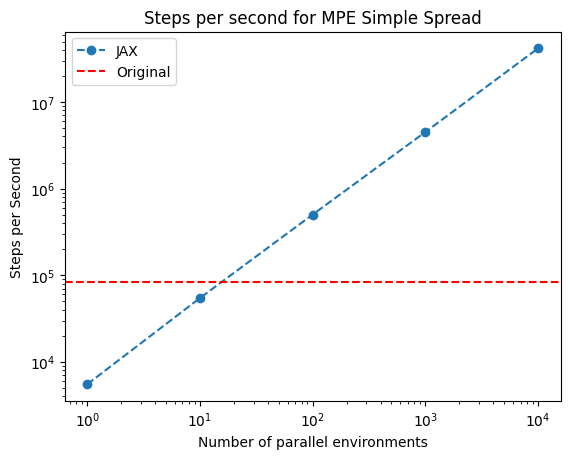

In [73]:
import matplotlib.pyplot as plt

vals = [1, 10, 100, 1000, 10000]
sps = [1000* v / s for v, s in zip(vals, speed_simple_spread)]

plt.plot(vals, sps, linestyle='--', marker='o', label="JAX")
plt.axhline(y=83407.43388772309, color='r', linestyle='--', label="Original")
plt.legend()

plt.ylabel("Steps per Second")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of parallel environments")
plt.title("Steps per second for MPE Simple Spread")
plt.savefig("JAXENV_simple_spread_speed.png")
plt.show()

In [41]:
all_results[("og_MPE_simple_spread_v3", 1)] = all_results[("og_simple_spread_v3", 1)]
del all_results[("og_simple_spread_v3", 1)]
all_results[("og_MPE_simple_reference_v3", 1)] = all_results[("og_simple_reference_v3", 1)]
del all_results[(("og_simple_reference_v3", 1))]
all_results[("og_switch_riddle", 1)] = all_results[("og_switch", 1)]
del all_results[(("og_switch", 1))]

for k in all_results.keys():
    print(k)

('MPE_simple_spread_v3', 1)
('MPE_simple_spread_v3', 100)
('MPE_simple_spread_v3', 10000)
('MPE_simple_reference_v3', 1)
('MPE_simple_reference_v3', 100)
('MPE_simple_reference_v3', 10000)
('switch_riddle', 1)
('switch_riddle', 100)
('switch_riddle', 10000)
('hanabi', 1)
('hanabi', 100)
('hanabi', 10000)
('og_hanabi', 1)
('overcooked', 1)
('overcooked', 100)
('overcooked', 10000)
('og_overcooked', 1)
('ant_4x2', 1)
('ant_4x2', 100)
('ant_4x2', 10000)
('og_ant_4x2', 1)
('2s3z', 1)
('2s3z', 100)
('2s3z', 10000)
('27m_vs_30m', 1)
('27m_vs_30m', 100)
('27m_vs_30m', 10000)
('og_2s3z', 1)
('og_27m_vs_30m', 1)
('mg_in_the_grid_2p', 1)
('mg_in_the_grid_2p', 100)
('mg_in_the_grid_2p', 10000)
('coin_game', 1)
('coin_game', 100)
('coin_game', 10000)
('og_coin_game', 1)
('og_mg_in_the_grid_2p', 1)
('og_MPE_simple_spread_v3', 1)
('og_MPE_simple_reference_v3', 1)
('og_switch_riddle', 1)


In [38]:
all_results[("og_MPE_simple_spread_v3", 1)]

83407.43388772309

In [39]:
all_results.keys()

dict_keys([('MPE_simple_spread_v3', 1), ('MPE_simple_spread_v3', 100), ('MPE_simple_spread_v3', 10000), ('MPE_simple_reference_v3', 1), ('MPE_simple_reference_v3', 100), ('MPE_simple_reference_v3', 10000), ('switch_riddle', 1), ('switch_riddle', 100), ('switch_riddle', 10000), ('hanabi', 1), ('hanabi', 100), ('hanabi', 10000), ('og_hanabi', 1), ('overcooked', 1), ('overcooked', 100), ('overcooked', 10000), ('og_overcooked', 1), ('ant_4x2', 1), ('ant_4x2', 100), ('ant_4x2', 10000), ('og_ant_4x2', 1), ('2s3z', 1), ('2s3z', 100), ('2s3z', 10000), ('27m_vs_30m', 1), ('27m_vs_30m', 100), ('27m_vs_30m', 10000), ('og_2s3z', 1), ('og_27m_vs_30m', 1), ('mg_in_the_grid_2p', 1), ('mg_in_the_grid_2p', 100), ('mg_in_the_grid_2p', 10000), ('coin_game', 1), ('coin_game', 100), ('coin_game', 10000), ('og_coin_game', 1), ('og_mg_in_the_grid_2p', 1), ('og_MPE_simple_spread_v3', 1), ('og_MPE_simple_reference_v3', 1), ('og_switch_riddle', 1)])

In [43]:
jnp.save("all_results_2.npy", all_results)

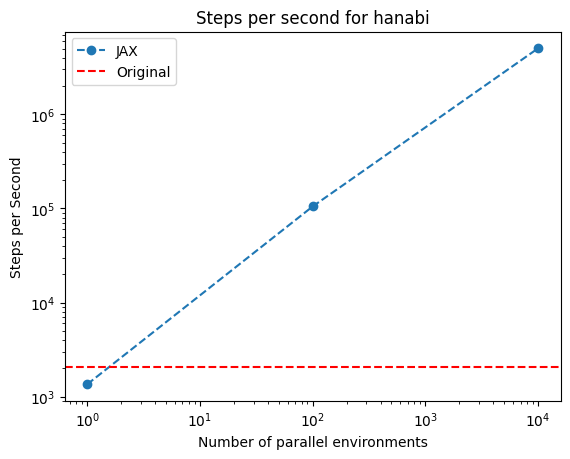

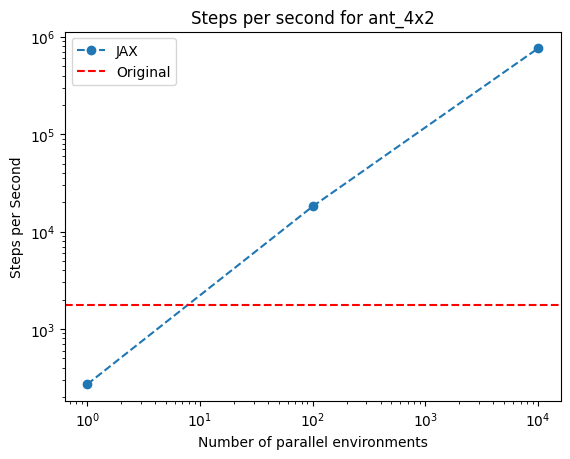

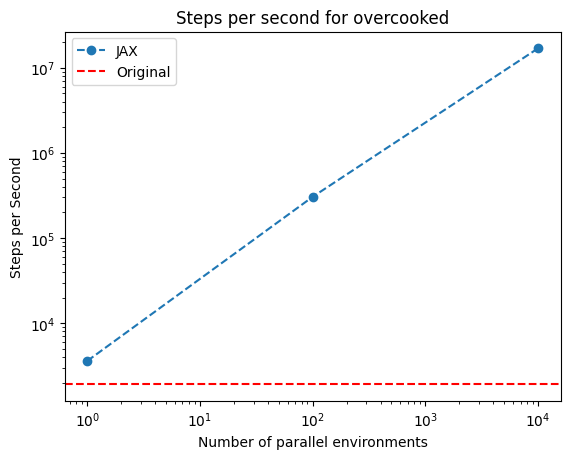

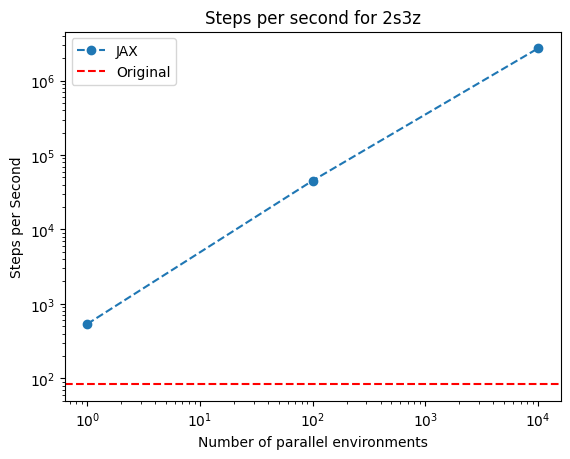

In [45]:
import matplotlib.pyplot as plt

all_results = jnp.load("all_results_2.npy", allow_pickle=True).item()

benchmark_nums = [1, 100, 10000]
for env in ["hanabi", "ant_4x2", "overcooked", "2s3z"]:
    sps = []
    for num_envs in benchmark_nums:
        sps.append(all_results[(env, num_envs)])
    plt.plot(benchmark_nums, sps, linestyle='--', marker='o', label="JAX")
    plt.axhline(y=all_results[(f"og_{env}", 1)], color='r', linestyle='--', label="Original")
    plt.legend()

    plt.ylabel("Steps per Second")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Number of parallel environments")
    plt.title(f"Steps per second for {env}")
    # plt.savefig("JAXENV_overcooked_speed.png")
    plt.show()


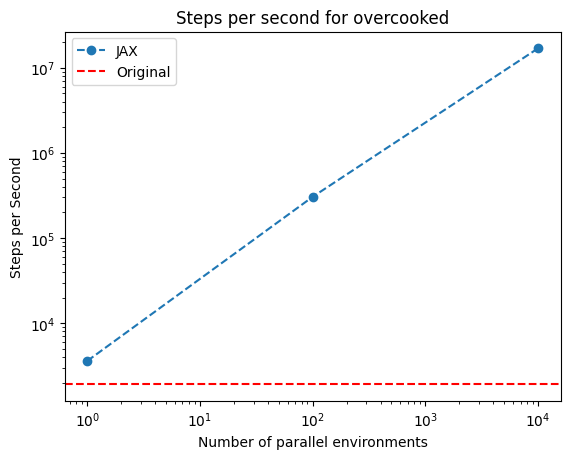

In [74]:
env = "overcooked"
sps = []
for num_envs in benchmark_nums:
    sps.append(all_results[(env, num_envs)])
plt.plot(benchmark_nums, sps, linestyle='--', marker='o', label="JAX")
plt.axhline(y=all_results[("og_overcooked", 1)], color='r', linestyle='--', label="Original")
plt.legend()

plt.ylabel("Steps per Second")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of parallel environments")
plt.title(f"Steps per second for {env}")
plt.savefig("JAXENV_overcooked_speed.png")
plt.show()


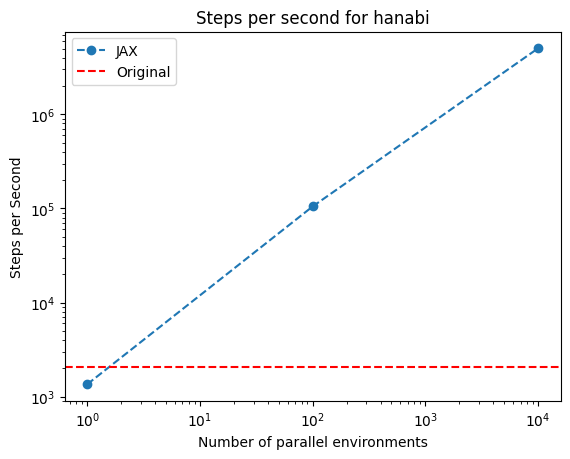

In [75]:
env = "hanabi"
sps = []
for num_envs in benchmark_nums:
    sps.append(all_results[(env, num_envs)])
plt.plot(benchmark_nums, sps, linestyle='--', marker='o', label="JAX")
plt.axhline(y=all_results[("og_hanabi", 1)], color='r', linestyle='--', label="Original")
plt.legend()

plt.ylabel("Steps per Second")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of parallel environments")
plt.title(f"Steps per second for {env}")
plt.savefig("JAXENV_hanabi_speed.png")
plt.show()


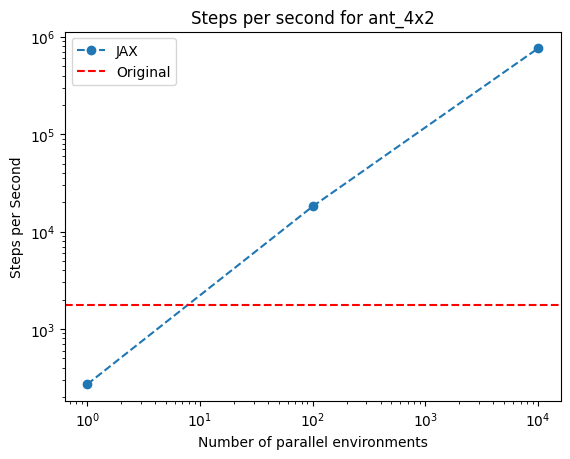

In [24]:
env = "ant_4x2"
sps = []
for num_envs in benchmark_nums:
    sps.append(all_results[(env, num_envs)])
plt.plot(benchmark_nums, sps, linestyle='--', marker='o', label="JAX")
plt.axhline(y=all_results[("og_ant_4x2", 1)], color='r', linestyle='--', label="Original")
plt.legend()

plt.ylabel("Steps per Second")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of parallel environments")
plt.title(f"Steps per second for {env}")
plt.savefig("JAXENV_ant_speed.png")
plt.show()


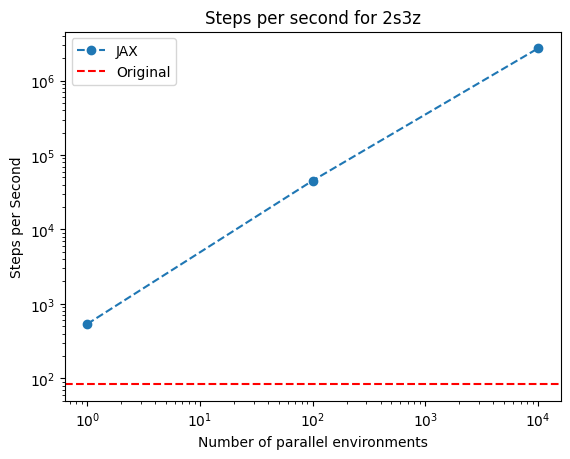

In [23]:
env = "2s3z"
sps = []
for num_envs in benchmark_nums:
    sps.append(all_results[(env, num_envs)])
plt.plot(benchmark_nums, sps, linestyle='--', marker='o', label="JAX")
plt.axhline(y=all_results[("og_2s3z", 1)], color='r', linestyle='--', label="Original")
plt.legend()

plt.ylabel("Steps per Second")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of parallel environments")
plt.title(f"Steps per second for {env}")
plt.savefig("JAXENV_2s3z_speed.png")
plt.show()


# IPPO BENCHMARKING

## MPE

In [57]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
import smax
from smax.wrappers.smaxbaselines import LogWrapper
import matplotlib.pyplot as plt

class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)
    
class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray

def batchify(x: dict, agent_list, num_actors):
    x = jnp.stack([x[a] for a in agent_list])
    return x.reshape((num_actors, -1))

def unbatchify(x: jnp.ndarray, agent_list, num_envs, num_actors):
    x = x.reshape((num_actors, num_envs, -1))
    return {a: x[i] for i, a in enumerate(agent_list)}

def make_train(config):
    env = smax.make(config["ENV_NAME"], **config["ENV_KWARGS"])
    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ACTORS"]  # Q: NUM_ACTORS CORRECT?
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ACTORS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    
    env = LogWrapper(env)
    
    def linear_schedule(count):
        frac = 1.0 - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"])) / config["NUM_UPDATES"]
        return config["LR"] * frac

    def train(rng):

        # INIT NETWORK
        network = ActorCritic(env.action_space(env.agents[0]).n, activation=config["ACTIVATION"])
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env.agents[0]).shape)
        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), optax.adam(config["LR"], eps=1e-5))

        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )
        
        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset)(reset_rng)
        
        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])
                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                
                pi, value = network.apply(train_state.params, obs_batch)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)
                env_act = unbatchify(action, env.agents, config["NUM_ENVS"], env.num_agents)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = jax.vmap(env.step)(
                    rng_step, env_state, env_act,
                )

                info = jax.tree_map(lambda x: x.reshape((config["NUM_ACTORS"])), info)
                transition = Transition(
                    batchify(done, env.agents, config["NUM_ACTORS"]).squeeze(),
                    action,
                    value,
                    batchify(reward, env.agents, config["NUM_ACTORS"]).squeeze(),
                    log_prob,
                    obs_batch,
                    info,
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )
            
            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            last_obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])
            _, last_val = network.apply(train_state.params, last_obs_batch)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=8,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)
            
            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ACTORS"]
                ), "batch size must be equal to number of steps * number of actors"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]
            
            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, metric = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )
        return {"runner_state": runner_state, "metrics": metric}

    return train

In [58]:
config = {
    "LR": 0.0005,
    "NUM_ENVS": 25,
    "NUM_STEPS": 128,
    "TOTAL_TIMESTEPS": 3e6,
    "UPDATE_EPOCHS": 5,
    "NUM_MINIBATCHES": 2,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 1.0,
    "CLIP_EPS": 0.3,
    "ENT_COEF": 0.01,
    "VF_COEF": 1.0,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "ENV_NAME": "MPE_simple_spread_v3",
    "ENV_KWARGS": {},
    "ANNEAL_LR": True,
}

rng = jax.random.PRNGKey(20)
train_jit = jax.jit(make_train(config))
out = train_jit(rng)

In [65]:
rng, _rng = jax.random.split(rng)
_rngs = jax.random.split(_rng, 3)
train_vjit = jax.jit(jax.vmap(make_train(config), in_axes=(0,)))
out = train_vjit(_rngs)

In [66]:
import matplotlib.pyplot as plt
# test = out['metrics']['returned_episode_returns'][1:, 0].mean(-1).reshape((-1,))
# plt.plot(test)

In [68]:
out['metrics']['returned_episode_returns'].shape

(3, 312, 128, 75)

In [71]:
out['metrics']['returned_episode_returns'][:,i].shape

(3, 128, 75)

In [72]:
out['metrics']['returned_episode'][:,i].shape

(3, 128, 75)

In [76]:
huh = []
num_updates = out['metrics']['returned_episode_returns'].shape[1]
for i in range(num_updates):
    arr = []
    for j in range(3):
        arr.append(out['metrics']['returned_episode_returns'][j,i][out['metrics']['returned_episode'][j,i]].mean() * 4.0)
    huh.append(jnp.array(arr))
# hmm = out['metrics']['returned_episode_returns'][out['metrics']['returned_episode']]
# hmm * 3

In [89]:
jax_returns = jnp.stack(huh, axis=-1)

In [90]:
jax_returns.shape

(3, 312)

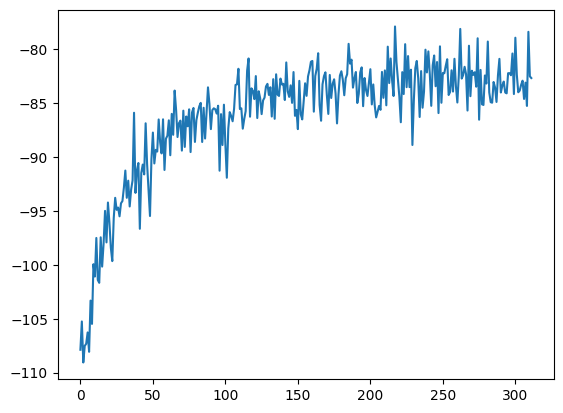

In [77]:
plt.plot([h[0] for h in huh])

In [ ]:
import time
config = {
    "LR": 0.0005,
    "NUM_ENVS": 25,
    "NUM_STEPS": 128,
    "TOTAL_TIMESTEPS": 3e6,
    "UPDATE_EPOCHS": 5,
    "NUM_MINIBATCHES": 2,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 1.0,
    "CLIP_EPS": 0.3,
    "ENT_COEF": 0.01,
    "VF_COEF": 1.0,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "ENV_NAME": "MPE_simple_spread_v3",
    "ENV_KWARGS": {},
    "ANNEAL_LR": True,
}

# rng = jax.random.PRNGKey(30)
# train_jit = jax.jit(make_train(config))
# out = train_jit(rng)

times = []
rng = jax.random.PRNGKey(42)
for i in range(11):
    print(f"Running {2**i} in parallel")
    rng, _rng = jax.random.split(rng)
    _rngs = jax.random.split(_rng, 2**i)
    train_vjit = jax.jit(jax.vmap(make_train(config), in_axes=(0,)))
    benchmark_jit = train_vjit.lower(_rngs).compile()
    before = time.time()
    runner_state = jax.block_until_ready(benchmark_jit(_rngs))
    after = time.time()
    total_time = (after - before)
    print(f"Total Time (s): {total_time}")
    times.append(total_time)

jnp.save("mpe_times.npy", jnp.array(times))

In [64]:
# jnp.save("mpe_times_new.npy", jnp.array(times))

In [95]:
times = jnp.load("mpe_times_new.npy")

In [96]:
times

Array([  9.775979,  11.211319,  11.791821,  12.693106,  14.65333 ,
        17.519222,  22.730526,  34.41179 ,  57.079327, 103.920135,
       198.35457 ], dtype=float32)

In [86]:

def plot_curve_with_std(curve, x_mult=1, label=""):
    mean = curve.mean(0)
    xs = jnp.arange(len(mean))*x_mult
    std = jnp.std(curve, axis=0) # / jnp.sqrt(curve.shape[0])
    results_max = mean + std
    results_min = mean - std
    plt.plot(xs, mean, label=label)
    plt.fill_between(x=xs, y1=results_min, y2=results_max, alpha=0.5)
    # plt.title(title)
    # plt.xlabel("Frames")
    # plt.ylabel("Return")


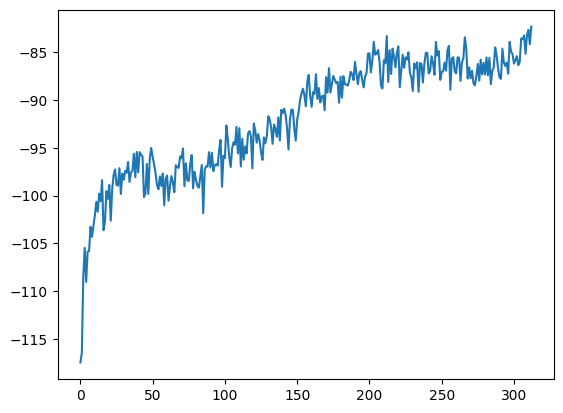

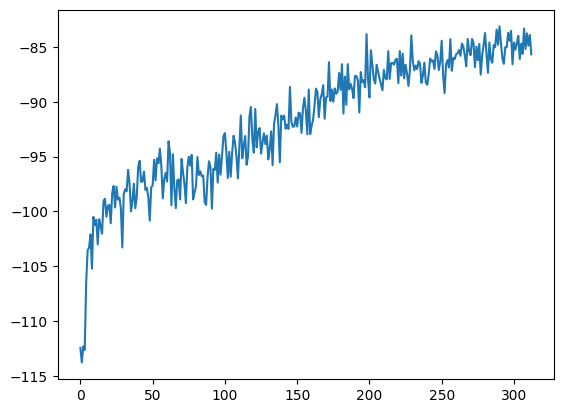

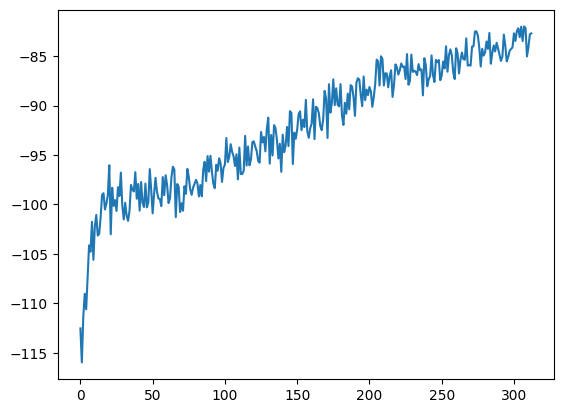

In [82]:
import json
import os

folder_start = "/home/clu/smax_speed_blines/MARLlib/exp_results/ippo_mlp_simple_spread"

folder_names = [
    "IPPOTrainer_mpe_simple_spread_55156_00000_0_2023-10-05_18-40-53",
    "IPPOTrainer_mpe_simple_spread_8942b_00000_0_2023-10-05_18-42-21",
    "IPPOTrainer_mpe_simple_spread_9151f_00000_0_2023-10-05_18-42-35",
]


all_times = []
all_returns = []
for folder_name in folder_names:
    folder = os.path.join(folder_start, folder_name)
    times = []
    returns = []
    frames = []
    # wat = []
    with open(os.path.join(folder, "result.json"), 'r') as file:
        for line in file:
            l = json.loads(line)
            times.append(l["time_total_s"])
            returns.append(l["episode_reward_mean"])
            # wat.append(l["policy_reward_mean"]["shared_policy"])
    all_times.append(jnp.array(times))
    all_returns.append(jnp.array(returns))
    plt.plot(returns)
    plt.show()


In [83]:
all_times_stack = jnp.stack(all_times, axis=0)
all_returns_stack = jnp.stack(all_returns, axis=0)

In [93]:
all_times_stack[:,-1]

Array([2518.9338, 2498.8083, 2289.2686], dtype=float32)

In [21]:
len(times)

11

In [22]:
jax_returns.shape

(3, 312)

In [24]:
# jnp.save("mpe_data.npy", data)

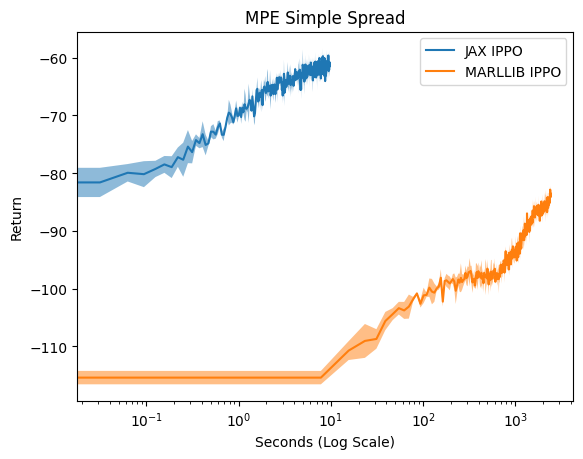

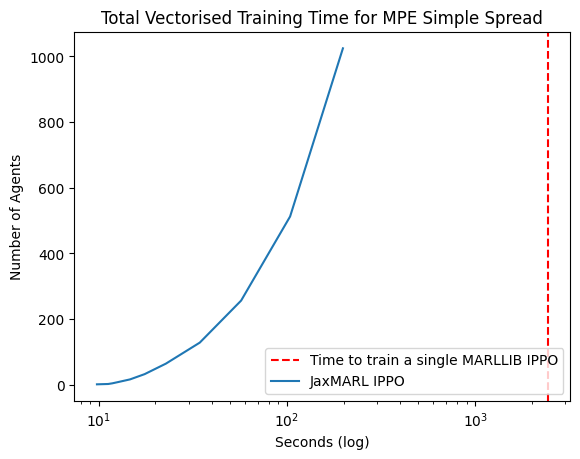

In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np

def plot_curve_with_std(curve, x_mult=1, label=""):
    mean = curve.mean(0)
    xs = jnp.arange(len(mean))*x_mult
    std = jnp.std(curve, axis=0) # / jnp.sqrt(curve.shape[0]) <= standard error vs. stdev
    results_max = mean + std
    results_min = mean - std
    plt.plot(xs, mean, label=label)
    plt.fill_between(x=xs, y1=results_min, y2=results_max, alpha=0.5)

data = jnp.load("mpe_data.npy", allow_pickle=True).item()
jax_returns = data["jax_returns"]
all_returns_stack = data["all_return_stack"]
all_times_stack = data["all_times_stack"]
times = data["times"]

# plot_curve_with_std(jax_returns, x_mult=times[0] / 312.0, label="JAX IPPO")
plot_curve_with_std(jax_returns * 3/4, x_mult=times[0] / 312.0, label="JAX IPPO")
plot_curve_with_std(all_returns_stack, x_mult=all_times_stack[:,-1].mean() / 312.0, label="MARLLIB IPPO")
plt.xscale("log")
plt.xlabel("Seconds (Log Scale)")
plt.ylabel("Return")
plt.title("MPE Simple Spread")
plt.legend()
plt.show()

num_agents = 2**np.arange(len(times))

plt.axvline(x=all_times_stack[:,-1].mean(), color="r", linestyle="--", label="Time to train a single MARLLIB IPPO")
plt.plot(times, num_agents, label="JaxMARL IPPO")
plt.xscale("log")
plt.xlabel("Seconds (log)")
plt.ylabel("Number of Agents")
plt.legend()
plt.title("Total Vectorised Training Time for MPE Simple Spread")
plt.show()


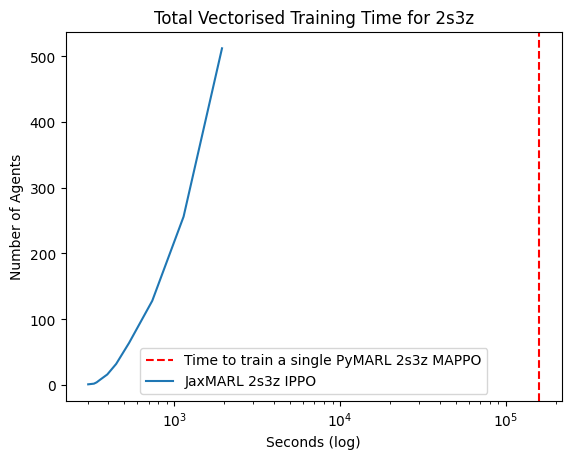

In [26]:
smax_times = jnp.load("smax_times_9.npy", allow_pickle=True)
num_agents = 2**np.arange(len(smax_times))

plt.axvline(x=158460, color="r", linestyle="--", label="Time to train a single PyMARL 2s3z MAPPO") # Data from Ben's wandb
plt.plot(smax_times, num_agents, label="JaxMARL 2s3z IPPO")
plt.xscale("log")
plt.xlabel("Seconds (log)")
plt.ylabel("Number of Agents")
plt.legend()
plt.title("Total Vectorised Training Time for 2s3z")
# plt.savefig("2s3z_vec_speeds.png", dpi=300)
plt.show()

In [140]:
# all_data = {
#     "jax_returns": jax_returns,
#     "all_return_stack": all_returns_stack,
#     "all_times_stack": all_times_stack,
#     "times": times,
# }
# jnp.save("all_data.npy", all_data)

In [2]:
test = jnp.load("all_data.npy", allow_pickle=True).item()

In [3]:
jax_returns = test["jax_returns"]
all_returns_stack = test["all_return_stack"]
all_times_stack = test["all_times_stack"]
times = test["times"]


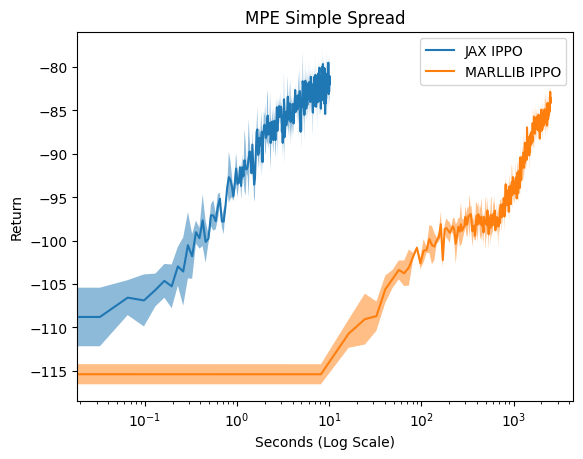

In [4]:
# import seaborn as sns
plot_curve_with_std(jax_returns, x_mult=times[0] / 300.0, label="JAX IPPO")
plot_curve_with_std(all_returns_stack, x_mult=all_times_stack[:,-1].mean() / 300.0, label="MARLLIB IPPO")
plt.xscale("log")
plt.xlabel("Seconds (Log Scale)")
plt.ylabel("Return")
plt.title("MPE Simple Spread")
plt.legend()
plt.savefig("mpe_returns.png", dpi=300)

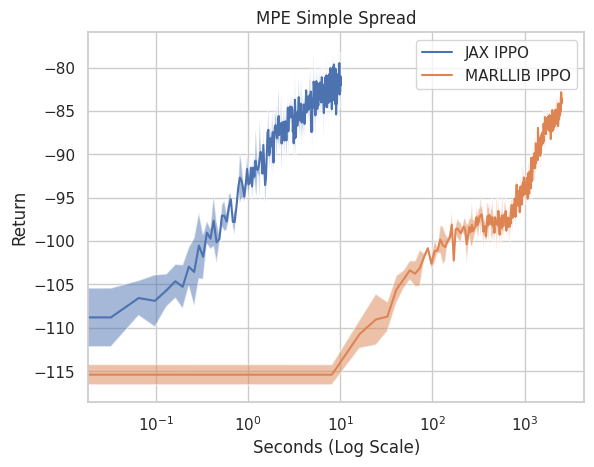

In [138]:
# import seaborn as sns
plot_curve_with_std(jax_returns, x_mult=times[0] / 300.0, label="JAX IPPO")
plot_curve_with_std(all_returns_stack, x_mult=all_times_stack[:,-1].mean() / 300.0, label="MARLLIB IPPO")
plt.xscale("log")
plt.xlabel("Seconds (Log Scale)")
plt.ylabel("Return")
plt.title("MPE Simple Spread")
plt.legend()
plt.savefig("mpe_returns.png", dpi=300)

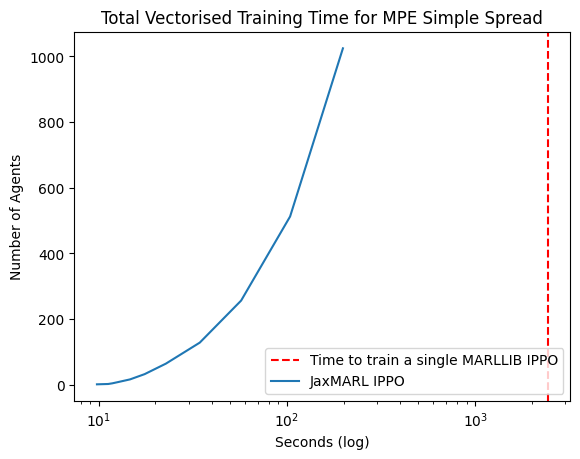

In [5]:
num_agents = 2**np.arange(len(times))

plt.axvline(x=all_times_stack[:,-1].mean(), color="r", linestyle="--", label="Time to train a single MARLLIB IPPO")
plt.plot(times, num_agents, label="JaxMARL IPPO")
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Seconds (log)")
plt.ylabel("Number of Agents")
plt.legend()
plt.title("Total Vectorised Training Time for MPE Simple Spread")
plt.savefig("mpe_vec_speeds.png", dpi=300)


In [14]:
all_times_stack[:,-1].mean()

Array(2435.6704, dtype=float32)

In [15]:
test["times"]

Array([  9.775979,  11.211319,  11.791821,  12.693106,  14.65333 ,
        17.519222,  22.730526,  34.41179 ,  57.079327, 103.920135,
       198.35457 ], dtype=float32)

In [17]:
2**np.arange(len(test["times"]))

array([   1,    2,    4,    8,   16,   32,   64,  128,  256,  512, 1024])

## SMAX

In [6]:
smax_times = jnp.load("smax_times_9.npy", allow_pickle=True)

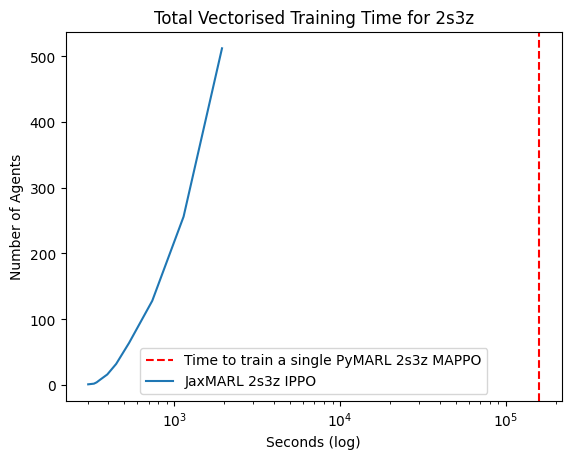

In [11]:
num_agents = 2**np.arange(len(smax_times))

plt.axvline(x=158460, color="r", linestyle="--", label="Time to train a single PyMARL 2s3z MAPPO")
plt.plot(smax_times, num_agents, label="JaxMARL 2s3z IPPO")
plt.xscale("log")
plt.xlabel("Seconds (log)")
plt.ylabel("Number of Agents")
plt.legend()
plt.title("Total Vectorised Training Time for 2s3z")
plt.savefig("2s3z_vec_speeds.png", dpi=300)

In [5]:
import wandb

def make_log(config):
    # mgr_options = orbax.checkpoint.CheckpointManagerOptions(create=True, max_to_keep=3)
    # ckpt_mgr = orbax.checkpoint.CheckpointManager(
    #     os.path.join(wandb.run.dir, config["CHECKPOINT_DIR"]),
    #     orbax.checkpoint.Checkpointer(orbax.checkpoint.PyTreeCheckpointHandler()),
    #     mgr_options,
    # )

    def log(out, rng, steps, update_steps):
        steps = int(steps[0])
        update_steps = int(update_steps[0])
        train_state = out["runner_state"][0]
        # if config["SAVE_GIF"]:
        #     rng, rng_gif = jax.random.split(rng)
        #     rng_gif = jax.random.split(rng_gif, num=config["NUM_SEEDS"])
        #     gif_rollout_vmap = jax.vmap(
        #         make_rollout_for_gif(config, config["MAP_NAME"])
        #     )
        #     viz_state, _ = gif_rollout_vmap(train_state, rng_gif)
        #     make_gifs(
        #         config,
        #         config["MAP_NAME"],
        #         viz_state,
        #         num_steps=config["NUM_STEPS"],
        #         num_seeds=config["NUM_SEEDS"],
        #     )
        # if config["SAVE_RUNNER_STATE"]:
        #     save_args = orbax_utils.save_args_from_target(out["runner_state"])
        #     ckpt_mgr.save(
        #         steps,
        #         out["runner_state"],
        #         save_kwargs={"save_args": save_args},
        #     )
        returns = out["metrics"]["returned_episode_returns"].mean()
        std = out["metrics"]["returned_episode_returns"].std()
        metrics = {
            "entropy": jnp.mean(out["metrics"]["entropy"]),
            "ratio_min": jnp.min(out["metrics"]["min_ratio"]),
            "ratio_max": jnp.max(out["metrics"]["max_ratio"]),
            "value_loss": jnp.mean(out["metrics"]["value_loss"]),
            "total_loss": jnp.mean(out["metrics"]["total_loss"]),
            "loss_actor": jnp.mean(out["metrics"]["loss_actor"]),
            "returns": returns,
            "win_rate": jnp.mean(out["metrics"]["win_rate"]),
            "std": std,
            "env_step": steps,
        }
        wandb.log(metrics)

    return log

In [2]:
import jax
import jax.numpy as jnp
import flax.linen as nn
# import hydra
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper
import smax
from smax.environments.mini_smac import map_name_to_scenario
from smax.wrappers.smaxbaselines import SMAXLogWrapper
from smax.wrappers.gymnax import GymnaxToSMAX
# from utils import batchify, unbatchify
# from omegaconf import DictConfig, OmegaConf
# import orbax.checkpoint
# from flax.training import orbax_utils
import wandb
import uuid
import matplotlib.pyplot as plt
import os

import jax.numpy as jnp

def batchify(x: dict, agent_list, num_actors):
    x = jnp.stack([x[a] for a in agent_list])
    return x.reshape((num_actors, -1))
    

def unbatchify(x: dict, agent_list, num_envs, num_actors):
    x = x.reshape((num_actors, num_envs, -1))
    return {a: x[i] for i, a in enumerate(agent_list)}

class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)


class Transition(NamedTuple):
    # need both global_done and done
    # because gae is computed using global_done
    # and done is used to present a training mask
    global_done: jnp.ndarray
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray
    avail_actions: jnp.ndarray


def make_train(config):
    scenario = map_name_to_scenario(config["MAP_NAME"])
    env = smax.make(config["ENV_NAME"], scenario=scenario, **config["ENV_KWARGS"])
    # env = GymnaxToSMAX(config["ENV_NAME"], **config["ENV_KWARGS"])
    # env_params = env.default_params
    if config["SCALE_CLIP_EPS"]:
        config["CLIP_EPS"] = config["CLIP_EPS"] / env.num_agents
    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ACTORS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    config["NUM_OUTER_LOOPS"] = config["TOTAL_TIMESTEPS"] // config["LOG_FREQUENCY"]
    config["NUM_INNER_UPDATES"] = (
        config["LOG_FREQUENCY"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    rand_str = str(uuid.uuid4())[:6]
    config[
        "CHECKPOINT_DIR"
    ] = f"ckpt_{config['MAP_NAME']}_{config['SEED']}_wcd={config['ENV_KWARGS']['walls_cause_death']}_sea={config['ENV_KWARGS']['see_enemy_actions']}_{rand_str}"
    # env = FlattenObservationWrapper(env) # NOTE need a batchify wrapper
    env = SMAXLogWrapper(env)
    # log_fn = make_log(config)

    def linear_schedule(count):
        frac = (
            1.0
            - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"]))
            / config["NUM_UPDATES"]
        )
        return config["LR"] * frac

    def train_loop(rng):
        rng, _rng = jax.random.split(rng)
        init_rng = jax.random.split(_rng, num=config["NUM_SEEDS"])
        runner_state = jax.vmap(init_runner_state)(init_rng)
        steps = jnp.zeros((config["NUM_SEEDS"],))
        updates = jnp.zeros((config["NUM_SEEDS"],))
        train_vmap = jax.vmap(train)

        def loop_body(carry, unused):
            runner_state, rng, steps, updates = carry

            out = train_vmap(runner_state)
            steps += (
                config["NUM_INNER_UPDATES"] * config["NUM_ENVS"] * config["NUM_STEPS"]
            )
            updates += config["NUM_INNER_UPDATES"]
            rng, callback_rng = jax.random.split(rng)
            # jax.experimental.io_callback(
            #     log_fn, None, out, callback_rng, steps, updates
            # )
            return (out["runner_state"], rng, steps, updates), jnp.mean(out["metrics"]["win_rate"])

        rng, body_rng = jax.random.split(rng)
        runner_state, metrics = jax.lax.scan(
            loop_body,
            (runner_state, body_rng, steps, updates),
            None,
            config["NUM_OUTER_LOOPS"],
        )
        return {"runner_state": runner_state, "metrics": metrics}

    def init_runner_state(rng):
        # INIT NETWORK
        network = ActorCritic(
            env.action_space(env.agents[0]).n, activation=config["ACTIVATION"]
        )
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env.agents[0]).shape)
        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(config["LR"], eps=1e-5),
            )
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset)(reset_rng)

        return (train_state, env_state, obsv, rng)

    def train(runner_state):
        network = ActorCritic(
            env.action_space(env.agents[0]).n, activation=config["ACTIVATION"]
        )

        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)

                obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])

                pi, value = network.apply(train_state.params, obs_batch)
                # transform using the available actions
                avail_actions = jax.vmap(env.get_avail_actions)(env_state.env_state)
                avail_actions = jax.lax.stop_gradient(
                    batchify(avail_actions, env.agents, config["NUM_ACTORS"])
                )
                # mask out unavailable actions
                logits = pi.logits - (1 - avail_actions) * 1e10
                pi = distrax.Categorical(logits=logits)

                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)
                env_act = unbatchify(
                    action, env.agents, config["NUM_ENVS"], env.num_agents
                )
                env_act = {k: v.squeeze() for k, v in env_act.items()}

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = jax.vmap(env.step)(
                    rng_step, env_state, env_act
                )
                info = jax.tree_map(lambda x: x.reshape((config["NUM_ACTORS"])), info)
                transition = Transition(
                    jnp.tile(done["__all__"], env.num_agents),
                    batchify(done, env.agents, config["NUM_ACTORS"]).squeeze(),
                    action,
                    value,
                    batchify(reward, env.agents, config["NUM_ACTORS"]).squeeze(),
                    log_prob,
                    obs_batch,
                    info,
                    avail_actions,
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            last_obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])
            _, last_val = network.apply(train_state.params, last_obs_batch)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.global_done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs)
                        # set masked values to a tiny prob to avoid NaNs when backpropping
                        logits = pi.logits - (1 - traj_batch.avail_actions) * 1e10
                        pi = distrax.Categorical(logits=logits)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = 0.5 * (
                            jnp.maximum(value_losses, value_losses_clipped)
                        ).mean(where=(1 - traj_batch.done))

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        min_ratio = jnp.log(jnp.min(ratio))
                        max_ratio = jnp.log(jnp.max(ratio))
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean(where=(1 - traj_batch.done))
                        entropy = pi.entropy().mean(where=(1 - traj_batch.done))

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (
                            value_loss,
                            loss_actor,
                            entropy,
                            min_ratio,
                            max_ratio,
                        )

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ACTORS"]
                ), "batch size must be equal to number of steps * number of actors"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            total_loss, loss_tuple = loss_info
            value_loss, loss_actor, entropy, min_ratio, max_ratio = loss_tuple
            loss_info = {
                "value_loss": value_loss,
                "loss_actor": loss_actor,
                "entropy": entropy,
                "min_ratio": min_ratio,
                "max_ratio": max_ratio,
                "total_loss": total_loss,
            }
            metric = {**traj_batch.info, **loss_info}
            rng = update_state[-1]

            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, metric

        runner_state, metric = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_INNER_UPDATES"]
        )
        return {"runner_state": runner_state, "metrics": metric}

    return train_loop, init_runner_state

In [8]:

rng = jax.random.PRNGKey(42)
config = {'LR': 0.004, 'NUM_ENVS': 64, 'SEED': 30, 'NUM_STEPS': 128, 'TOTAL_TIMESTEPS': 10000000.0, 'LOG_FREQUENCY': 100000, 'UPDATE_EPOCHS': 2, 'NUM_MINIBATCHES': 2, 'GAMMA': 0.99, 'GAE_LAMBDA': 0.95, 'CLIP_EPS': 0.2, 'SCALE_CLIP_EPS': False, 'ENT_COEF': 0.0, 'VF_COEF': 0.5, 'MAX_GRAD_NORM': 0.5, 'ACTIVATION': 'relu', 'ENV_NAME': 'HeuristicEnemyMiniSMAC', 'MAP_NAME': '2s3z', 'ENV_KWARGS': {'see_enemy_actions': True, 'walls_cause_death': True, 'attack_mode': 'closest'}, 'ANNEAL_LR': True, 'SAVE_GIF': False, 'EVALUATE_ONLY': False, 'CHECKPOINTS_TO_RESTORE': None, 'CHECKPOINT_MAP_NAMES': None, 'SAVE_RUNNER_STATE': False, 'DISABLE_JIT': False, 'ENTITY': 'flair', 'PROJECT': 'minismac', 'WANDB_MODE': 'online', 'NUM_SEEDS': 1, 'NUM_ACTORS': '???', 'NUM_UPDATES': '???', 'MINIBATCH_SIZE': '???', 'NUM_OUTER_LOOPS': '???'}
train_fn, _ = make_train(config)
train_jit = jax.jit(train_fn)
out = train_jit(rng)


In [10]:
out['metrics'].shape

(100,)

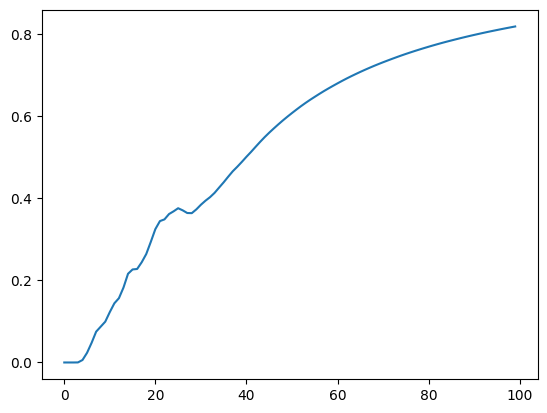

In [11]:
plt.plot(out['metrics'])

In [2]:

rng = jax.random.PRNGKey(42)
config = {'LR': 0.004, 'NUM_ENVS': 64, 'SEED': 30, 'NUM_STEPS': 128, 'TOTAL_TIMESTEPS': 10000000.0, 'LOG_FREQUENCY': 100000, 'UPDATE_EPOCHS': 2, 'NUM_MINIBATCHES': 2, 'GAMMA': 0.99, 'GAE_LAMBDA': 0.95, 'CLIP_EPS': 0.2, 'SCALE_CLIP_EPS': False, 'ENT_COEF': 0.0, 'VF_COEF': 0.5, 'MAX_GRAD_NORM': 0.5, 'ACTIVATION': 'relu', 'ENV_NAME': 'HeuristicEnemyMiniSMAC', 'MAP_NAME': '27m_vs_30m', 'ENV_KWARGS': {'see_enemy_actions': True, 'walls_cause_death': True, 'attack_mode': 'closest'}, 'ANNEAL_LR': True, 'SAVE_GIF': False, 'EVALUATE_ONLY': False, 'CHECKPOINTS_TO_RESTORE': None, 'CHECKPOINT_MAP_NAMES': None, 'SAVE_RUNNER_STATE': False, 'DISABLE_JIT': False, 'ENTITY': 'flair', 'PROJECT': 'minismac', 'WANDB_MODE': 'online', 'NUM_SEEDS': 1, 'NUM_ACTORS': '???', 'NUM_UPDATES': '???', 'MINIBATCH_SIZE': '???', 'NUM_OUTER_LOOPS': '???'}
train_fn, _ = make_train(config)
train_jit = jax.jit(train_fn)
out = train_jit(rng)



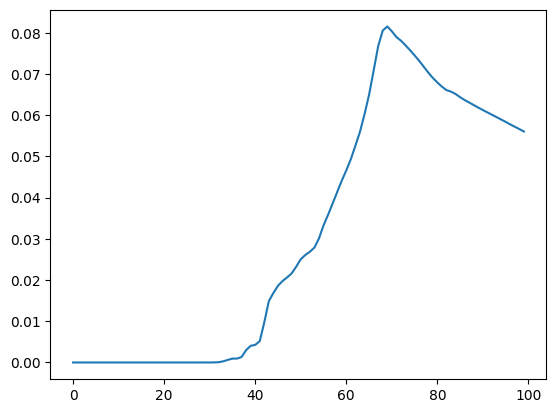

In [3]:
plt.plot(out['metrics'])

In [3]:

import time
config = {'LR': 0.004, 'NUM_ENVS': 64, 'SEED': 30, 'NUM_STEPS': 128, 'TOTAL_TIMESTEPS': 10000000.0, 'LOG_FREQUENCY': 100000, 'UPDATE_EPOCHS': 2, 'NUM_MINIBATCHES': 2, 'GAMMA': 0.99, 'GAE_LAMBDA': 0.95, 'CLIP_EPS': 0.2, 'SCALE_CLIP_EPS': False, 'ENT_COEF': 0.0, 'VF_COEF': 0.5, 'MAX_GRAD_NORM': 0.5, 'ACTIVATION': 'relu', 'ENV_NAME': 'HeuristicEnemyMiniSMAC', 'MAP_NAME': '2s3z', 'ENV_KWARGS': {'see_enemy_actions': True, 'walls_cause_death': True, 'attack_mode': 'closest'}, 'ANNEAL_LR': True, 'SAVE_GIF': False, 'EVALUATE_ONLY': False, 'CHECKPOINTS_TO_RESTORE': None, 'CHECKPOINT_MAP_NAMES': None, 'SAVE_RUNNER_STATE': False, 'DISABLE_JIT': False, 'ENTITY': 'flair', 'PROJECT': 'minismac', 'WANDB_MODE': 'online', 'NUM_SEEDS': 1, 'NUM_ACTORS': '???', 'NUM_UPDATES': '???', 'MINIBATCH_SIZE': '???', 'NUM_OUTER_LOOPS': '???'}

times = []
rng = jax.random.PRNGKey(42)
for i in range(10):
    print(f"Running {2**i} in parallel")
    config["NUM_SEEDS"] = 2**i
    train_fn, _ = make_train(config)
    benchmark_jit = jax.jit(train_fn).lower(rng).compile()
    before = time.time()
    runner_state = jax.block_until_ready(benchmark_jit(rng))
    after = time.time()
    total_time = (after - before)
    print(f"Total Time (s): {total_time}")
    times.append(total_time)
    jnp.save(f"smax_times_{i}.npy", jnp.array(times))


Running 1 in parallel


In [4]:
times

[302.62275314331055,
 327.75853419303894,
 340.21434116363525,
 357.08491134643555,
 394.5174481868744,
 446.1425590515137,
 533.881264925003,
 736.4560654163361,
 1137.777386188507,
 1939.7612705230713]

In [12]:
smax_times

Array([ 302.62274,  327.75854,  340.21436,  357.0849 ,  394.51746,
        446.14255,  533.8813 ,  736.45605, 1137.7773 , 1939.7612 ],      dtype=float32)

In [13]:
num_agents

array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512])

In [5]:
folder = "/home/clu/smax_speed_blines/MARLlib/exp_results/ippo_mlp_simple_spread/IPPOTrainer_mpe_simple_spread_fcc39_00000_0_2023-10-05_18-16-57"

In [8]:
asdf = open(os.path.join(folder, "progress.csv"), "r").read()

In [10]:
asdf = asdf.split("\n")
print(len(asdf))

155


In [12]:
asdf[1]

'-68.03966117073851,-187.80299486272722,-115.78887709063117,25.0,128,1,3200,0,9600,False,128,1,fcc39_00000,4ac729ff188c4992afe07e6fb2a4e657,2023-10-05_18-17-06,1696526226,8.098613023757935,8.098613023757935,2499323,4b7b884af2c6,172.17.0.2,8.098613023757935,0,1,-62.60099828757569,-22.679887056912822,-38.596292363543725,"[-112.52290542783514, -106.20230496571924, -118.75197283036525, -107.37427316586422, -93.61118502395057, -101.39313837196848, -128.45892610027798, -101.56921102699353, -138.48922975703405, -120.13075600054955, -134.7599398240155, -113.97242180460819, -187.80299486272722, -145.31581928762742, -137.6355259707509, -136.55018957670924, -158.969040368967, -141.67098527733256, -138.52263832776177, -88.53358255411035, -118.28898149197167, -142.43398838311106, -107.89181146792286, -106.65816841577407, -118.2417832295942, -124.05359122055039, -92.90870187059983, -145.98386090053774, -94.674192846792, -132.04651583703506, -105.09521901626968, -115.14215826806118, -118.650836220467

In [26]:
import pandas as pd
import os


df = pd.read_csv(os.path.join(folder, "progress.csv"))

In [27]:
df

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,num_healthy_workers,timesteps_total,timesteps_this_iter,agent_timesteps_total,done,...,info/learner/shared_policy/learner_stats/allreduce_latency,info/learner/shared_policy/learner_stats/cur_kl_coeff,info/learner/shared_policy/learner_stats/cur_lr,info/learner/shared_policy/learner_stats/total_loss,info/learner/shared_policy/learner_stats/policy_loss,info/learner/shared_policy/learner_stats/vf_loss,info/learner/shared_policy/learner_stats/vf_explained_var,info/learner/shared_policy/learner_stats/kl,info/learner/shared_policy/learner_stats/entropy,info/learner/shared_policy/learner_stats/entropy_coeff
0,-70.485881,-170.690028,-112.521083,25.0,128,1,3200,0,9600,False,...,0.0,0.2,0.0005,439.517823,-0.006689,439.539395,0.001251,0.005764,1.603674,0.01
1,-65.137020,-202.703661,-115.964257,25.0,128,1,6400,0,19200,False,...,0.0,0.2,0.0005,467.838509,-0.007584,467.860301,0.010729,0.008504,1.591478,0.01
2,-70.718195,-174.890077,-111.360440,25.0,128,1,9600,0,28800,False,...,0.0,0.2,0.0005,401.300530,-0.006299,401.321178,-0.017960,0.007051,1.575568,0.01
3,-67.675293,-164.625131,-109.025756,25.0,128,1,12800,0,38400,False,...,0.0,0.2,0.0005,324.863735,-0.006039,324.884147,-0.093257,0.006295,1.562530,0.01
4,-74.968239,-180.737783,-110.589978,25.0,128,1,16000,0,48000,False,...,0.0,0.2,0.0005,222.518560,-0.006260,222.539020,-0.123970,0.006824,1.556277,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,-56.473035,-117.786383,-82.163678,25.0,128,1,988800,0,2966400,False,...,0.0,0.1,0.0005,27.853880,-0.012046,27.875519,0.493161,0.007206,1.031404,0.01
309,-57.879844,-120.857734,-85.037269,25.0,128,1,992000,0,2976000,False,...,0.0,0.1,0.0005,27.742973,-0.013191,27.765698,0.520927,0.007451,1.027966,0.01
310,-62.100221,-111.791716,-84.119893,25.0,128,1,995200,0,2985600,False,...,0.0,0.1,0.0005,29.261516,-0.012933,29.284111,0.477367,0.007569,1.042034,0.01
311,-58.290016,-118.148124,-82.799480,25.0,128,1,998400,0,2995200,False,...,0.0,0.1,0.0005,26.735697,-0.012438,26.757730,0.505567,0.007187,1.031441,0.01


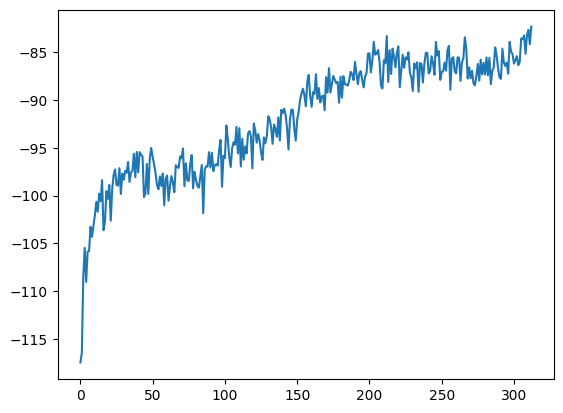

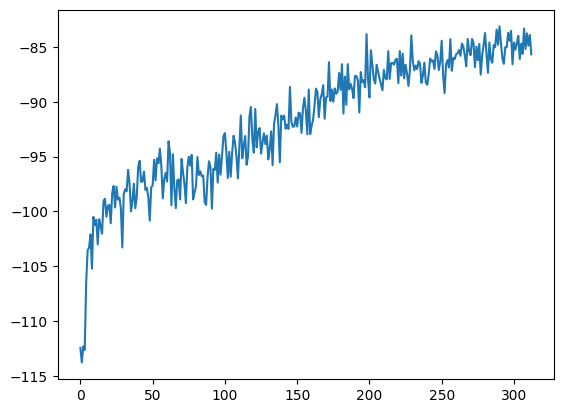

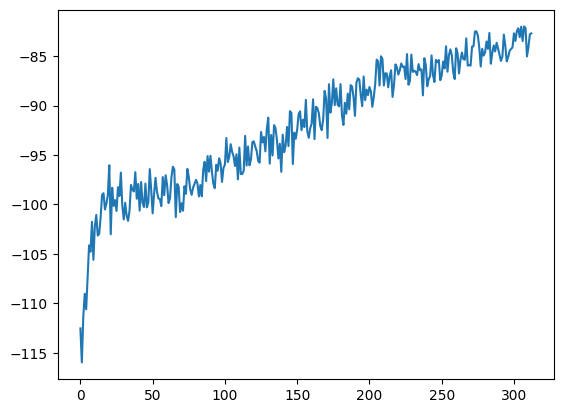

In [25]:
import json
import os
# whytf = []
# folder_start = "/home/clu/"
folder_start = "/home/clu/smax_speed_blines/MARLlib/exp_results/ippo_mlp_simple_spread"
folder_names = [
    "IPPOTrainer_mpe_simple_spread_55156_00000_0_2023-10-05_18-40-53",
    "IPPOTrainer_mpe_simple_spread_8942b_00000_0_2023-10-05_18-42-21",
    "IPPOTrainer_mpe_simple_spread_9151f_00000_0_2023-10-05_18-42-35",
    ]
for folder_name in folder_names:
    folder = os.path.join(folder_start, folder_name)
    times = []
    returns = []
    frames = []
    wat = []
    with open(os.path.join(folder, "result.json"), 'r') as file:
        for line in file:
            l = json.loads(line)
            times.append(l["time_total_s"])
            returns.append(l["episode_reward_mean"])
            wat.append(l["policy_reward_mean"]["shared_policy"])
            frames.append(l["timesteps_total"])
    plt.plot(returns)
    plt.show()


In [35]:
frames[-1]

1001600

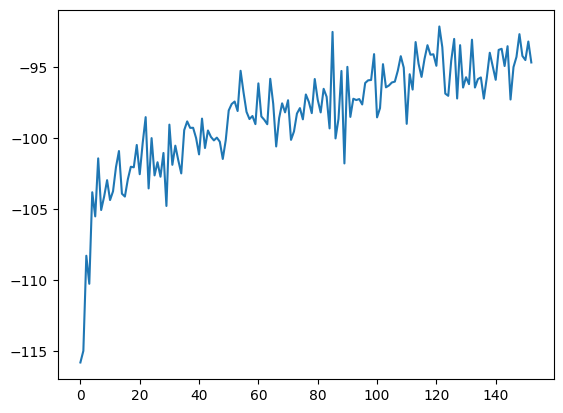

In [31]:
plt.plot([3*w for w in wat])

In [27]:
whytf[0]["policy_reward_mean"]

{'shared_policy': -38.596292363543725}

In [23]:
len(whytf)

153

In [24]:
whytf[0].keys()

dict_keys(['episode_reward_max', 'episode_reward_min', 'episode_reward_mean', 'episode_len_mean', 'episode_media', 'episodes_this_iter', 'policy_reward_min', 'policy_reward_max', 'policy_reward_mean', 'custom_metrics', 'hist_stats', 'sampler_perf', 'off_policy_estimator', 'num_healthy_workers', 'timesteps_total', 'timesteps_this_iter', 'agent_timesteps_total', 'timers', 'info', 'done', 'episodes_total', 'training_iteration', 'trial_id', 'experiment_id', 'date', 'timestamp', 'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip', 'config', 'time_since_restore', 'timesteps_since_restore', 'iterations_since_restore', 'perf'])

In [19]:
import json
asdf = json.load(open(os.path.join(folder, "result.json"), "r"))

JSONDecodeError: Extra data: line 2 column 1 (char 19868)

## HANABI

## Overcooked

In [92]:

import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper
import smax
from smax.wrappers.smaxbaselines import LogWrapper
from smax.wrappers.gymnax import GymnaxToSMAX
from smax.environments.overcooked import overcooked_layouts
from smax.viz.overcooked_visualizer import OvercookedVisualizer

import matplotlib.pyplot as plt

class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)
    

class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray

def get_rollout(train_state, config):
    env = smax.make(config["ENV_NAME"], **config["ENV_KWARGS"])
    # env_params = env.default_params
    # env = LogWrapper(env)

    network = ActorCritic(env.action_space().n, activation=config["ACTIVATION"])
    key = jax.random.PRNGKey(0)
    key, key_r, key_a = jax.random.split(key, 3)

    init_x = jnp.zeros(env.observation_space().shape)
    init_x = init_x.flatten()

    network.init(key_a, init_x)
    network_params = train_state.params

    done = False

    obs, state = env.reset(key_r)
    state_seq = [state]
    while not done:
        key, key_a0, key_a1, key_s = jax.random.split(key, 4)

        # obs_batch = batchify(obs, env.agents, config["NUM_ACTORS"])
        # breakpoint()
        obs = {k: v.flatten() for k, v in obs.items()}

        pi_0, _ = network.apply(network_params, obs["agent_0"])
        pi_1, _ = network.apply(network_params, obs["agent_1"])

        actions = {"agent_0": pi_0.sample(seed=key_a0), "agent_1": pi_1.sample(seed=key_a1)}
        # env_act = unbatchify(action, env.agents, config["NUM_ENVS"], env.num_agents)
        # env_act = {k: v.flatten() for k, v in env_act.items()}

        # STEP ENV
        obs, state, reward, done, info = env.step(key_s, state, actions)
        done = done["__all__"]

        state_seq.append(state)

    return state_seq

def batchify(x: dict, agent_list, num_actors):
    x = jnp.stack([x[a] for a in agent_list])
    return x.reshape((num_actors, -1))


def unbatchify(x: jnp.ndarray, agent_list, num_envs, num_actors):
    x = x.reshape((num_actors, num_envs, -1))
    return {a: x[i] for i, a in enumerate(agent_list)}

def make_train(config):
    env = smax.make(config["ENV_NAME"], **config["ENV_KWARGS"])
#     env = GymnaxToSMAX(config["ENV_NAME"], **config["ENV_KWARGS"])

    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ACTORS"] 
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ACTORS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    
    env = LogWrapper(env)
    
    def linear_schedule(count):
        frac = 1.0 - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"])) / config["NUM_UPDATES"]
        return config["LR"] * frac

    def train(rng):

        # INIT NETWORK
        network = ActorCritic(env.action_space().n, activation=config["ACTIVATION"])
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space().shape)
        
        init_x = init_x.flatten()
        
        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), optax.adam(config["LR"], eps=1e-5))
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )
        
        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0,))(reset_rng)
        
        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)

                obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])
                
                pi, value = network.apply(train_state.params, obs_batch)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)
                env_act = unbatchify(action, env.agents, config["NUM_ENVS"], env.num_agents)

                env_act = {k:v.flatten() for k,v in env_act.items()}

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])

                obsv, env_state, reward, done, info = jax.vmap(env.step, in_axes=(0,0,0))(
                    rng_step, env_state, env_act
                )
                info = jax.tree_map(lambda x: x.reshape((config["NUM_ACTORS"])), info)
                transition = Transition(
                    batchify(done, env.agents, config["NUM_ACTORS"]).squeeze(),
                    action,
                    value,
                    batchify(reward, env.agents, config["NUM_ACTORS"]).squeeze(),
                    log_prob,
                    obs_batch,
                    info
                    
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )
            
            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            last_obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])
            _, last_val = network.apply(train_state.params, last_obs_batch)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)
            
            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ACTORS"]
                ), "batch size must be equal to number of steps * number of actors"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]
            
            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, metric = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )
        return {"runner_state": runner_state, "metrics": metric}

    return train


Text(0, 0.5, 'Return')

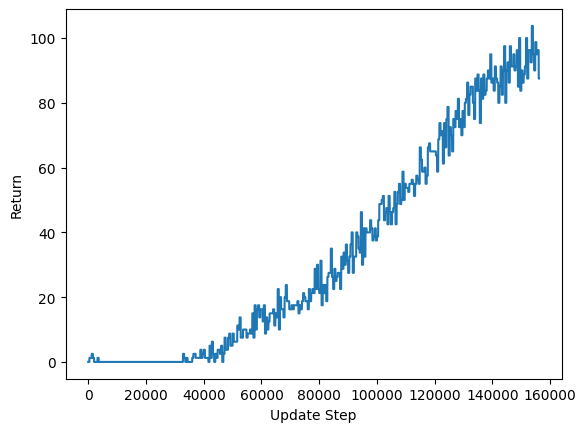

In [191]:
config = {
    "LR": 2.5e-4,
    "NUM_ENVS": 16,
    "NUM_STEPS": 128,
    "TOTAL_TIMESTEPS": 5e6,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": 4,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.01,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "ENV_NAME": "overcooked",
    # "ENV_KWARGS": {"layout" : overcooked_layouts["cramped_room"]},
    "ENV_KWARGS": {"layout" : overcooked_layouts["cramped_room"], "random_reset": False},
    "ANNEAL_LR": True,
}
rng = jax.random.PRNGKey(30)
with jax.disable_jit(False):
    train_jit = jax.jit(make_train(config))
    out = train_jit(rng)

filename = f'{config["ENV_NAME"]}_cramped_room_new'

plt.plot(out["metrics"]["returned_episode_returns"].mean(-1).reshape(-1))
plt.xlabel("Update Step")
plt.ylabel("Return")
# plt.savefig(f'{filename}.png')

# train_state = out["runner_state"][0]
# state_seq = get_rollout(train_state, config)
# viz = OvercookedVisualizer()
# # agent_view_size is hardcoded as it determines the padding around the layout.
# viz.animate(state_seq, agent_view_size=5, filename=f"{filename}.gif")

In [4]:
rng, _rng = jax.random.split(rng)
_rngs = jax.random.split(_rng, 3)
train_vjit = jax.jit(jax.vmap(make_train(config), in_axes=(0,)))
out = train_vjit(_rngs)

In [7]:
import time

times = []
rng = jax.random.PRNGKey(42)
for i in range(10):
    print(f"Running {2**i} in parallel")
    rng, _rng = jax.random.split(rng)
    _rngs = jax.random.split(_rng, 2**i)
    train_vjit = jax.jit(jax.vmap(make_train(config), in_axes=(0,)))
    benchmark_jit = train_vjit.lower(_rngs).compile()
    before = time.time()
    runner_state = jax.block_until_ready(benchmark_jit(_rngs))
    after = time.time()
    total_time = (after - before)
    print(f"Total Time (s): {total_time}")
    times.append(total_time)
    jnp.save("overcooked_times.npy", jnp.array(times))

Running 1 in parallel
Total Time (s): 50.824485540390015
Running 2 in parallel
Total Time (s): 55.999136447906494
Running 4 in parallel
Total Time (s): 56.956403732299805
Running 8 in parallel
Total Time (s): 58.286519050598145
Running 16 in parallel
Total Time (s): 63.86309099197388
Running 32 in parallel
Total Time (s): 74.6701934337616
Running 64 in parallel
Total Time (s): 95.5090742111206
Running 128 in parallel
Total Time (s): 131.9880290031433
Running 256 in parallel
Total Time (s): 201.775048494339
Running 512 in parallel
Total Time (s): 340.438538312912


In [192]:
import time
from overcooked_ai_py.mdp.overcooked_mdp import (
    ObjectState,
    OvercookedGridworld,
    OvercookedState,
    PlayerState,
    Recipe,
    SoupState,
)
from overcooked_ai_py.agents.agent import (
    AgentGroup,
    AgentPair,
    FixedPlanAgent,
    GreedyHumanModel,
    RandomAgent,
)
from overcooked_ai_py.mdp.overcooked_env import (
    DEFAULT_ENV_PARAMS,
    OvercookedEnv,
)

# from overcooked_ai_py.mdp.overcooked_env import OvercookedEnvPettingZoo
import gym

config = {
    "LR": 2.5e-4,
    "NUM_ENVS": 16,
    "NUM_STEPS": 128,
    "TOTAL_TIMESTEPS": 5e6,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": 4,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.01,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "ENV_NAME": "overcooked",
    "ENV_KWARGS": {"layout" : overcooked_layouts["cramped_room"], "random_reset": False},
    "ANNEAL_LR": True,
}

In [110]:
out.keys()

dict_keys(['metrics', 'runner_state'])

In [113]:
out['runner_state'][0].params.keys()

dict_keys(['params'])

In [115]:
apply_fn = out['runner_state'][0].apply_fn

In [ ]:
featurize_state_mdp

In [193]:
# ap = AgentPair(RandomAgent(all_actions=True), RandomAgent(all_actions=True))
# ap = AgentPair(FixedPlanAgent([]), FixedPlanAgent([]))
base_mdp = OvercookedGridworld.from_layout_name("cramped_room", old_dynamics=True)
env = OvercookedEnv.from_mdp(base_mdp, info_level=0, horizon=1000)
env_np = gym.make(
    "Overcooked-v0",
    base_env=env,
    # featurize_fn=env.featurize_state_mdp,
    featurize_fn=env.lossless_state_encoding_mdp,
)
env_smax = smax.make(config["ENV_NAME"], **config["ENV_KWARGS"])
# wrapped_env = OvercookedEnvPettingZoo(env,ap) # WTF?
# parallel_api_test(wrapped_env, num_cycles=1000)

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:20: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:25: UserWarning: WARN: It seems a Box observation space is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(


In [201]:

def batchify(x: dict, agent_list, num_actors):
    x = jnp.stack([x[a] for a in agent_list])
    return x.reshape((num_actors, -1))

def unbatchify(x: jnp.ndarray, agent_list, num_envs, num_actors):
    if num_envs == 1:
        x = x.reshape((num_actors, -1))
    else:
        x = x.reshape((num_actors, num_envs, -1))
    return {a: x[i] for i, a in enumerate(agent_list)}


In [203]:

rng = jax.random.PRNGKey(10)
for i in range(10):
    use_jax = True
    done = False
    rng, _rng = jax.random.split(rng)
    if use_jax:
        obs, state = jax.jit(env_smax.reset)(_rng)
        obs_batch = batchify(obs, env_smax.agents, 2)
    else:
        obs = env_np.reset()
        obs_batch = jnp.stack(obs['both_agent_obs'], axis=0).swapaxes(2,1).reshape(2, -1)

    reward_return = 0
    while not done:
        pi, value = jax.jit(apply_fn)(out['runner_state'][0].params, obs_batch)
        rng, _rng = jax.random.split(rng)
        action = pi.sample(seed=_rng)
        if use_jax:
            env_act = unbatchify(action, env_smax.agents, 1, 2)
            # env_act = {k:v.flatten() for k,v in env_act.items()}
            env_act = {k:v[0] for k,v in env_act.items()}
            obs, state, reward, done_env, info = jax.jit(env_smax.step)(rng, state, env_act)
            obs_batch = batchify(obs, env_smax.agents, 2)
            reward_return += reward['agent_0']
            done = done_env['agent_0']
        else:
            env_act = [a.item() for a in action]
            obs, reward, done, info = env_np.step(env_act)
            obs_batch = jnp.stack(obs['both_agent_obs'], axis=0).swapaxes(2,1).reshape(2, -1)
            reward_return += reward
        print(reward_return)


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


KeyboardInterrupt: 

In [172]:
obs = env_np.reset()

In [173]:
jnp.stack(obs['both_agent_obs'], axis=0).swapaxes(2,1).reshape(2, -1)

Array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [42]:
rng = jax.random.PRNGKey(3)
obs_np = env_np.reset()
obs_smax, env_smax_state = env_smax.reset(rng)
obs_np['both_agent_obs'][0].swapaxes(1,0) - obs_smax['agent_0']

Array([[[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, -

In [194]:
obs_np = env_np.reset()
obs_np_to_jax = jnp.array(obs_np['both_agent_obs'][0].swapaxes(1,0))

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'dict'>`
  logger.warn(


In [198]:
rng = jax.random.PRNGKey(12)
rngs = jax.random.split(rng, 10000)
obs_smax, env_smax_state = jax.jit(jax.vmap(env_smax.reset))(rngs)

In [195]:
rng = jax.random.PRNGKey(3)
obs_smax, env_smax_state = env_smax.reset(rng)

In [196]:
obs_smax['agent_0'] - obs_np_to_jax[None,:]

Array([[[[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],

        [[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]

In [197]:
jnp.abs(obs_smax['agent_0'] - obs_np_to_jax[None,:]).sum()

Array(6, dtype=int32)

In [68]:
obs_smax['agent_0'].shape

(4, 5, 26)

In [200]:

for i in range(100):
    obs_np = env_np.reset()
    obs_np_to_jax_new = jnp.array(obs_np['both_agent_obs'][0].swapaxes(1,0))
    # print(jnp.abs(obs_np_to_jax_new - obs_np_to_jax).sum())
    # rng = jax.random.PRNGKey(3)
    # rngs = jax.random.split(rng, 10000)
    # obs_smax, env_smax_state = jax.jit(jax.vmap(env_smax.reset))(rngs)
    shit = jnp.abs(obs_smax['agent_0'] - obs_np_to_jax_new[None,:]).reshape(10000, -1).sum(-1)
    print(shit)
    print(shit.min())
    if jnp.any(shit == 0):
        print("WAT")
        break


[8 8 8 ... 8 8 8]
8
[8 8 8 ... 8 8 8]
8
[6 6 6 ... 6 4 6]
4
[6 6 6 ... 6 4 6]
4
[8 8 8 ... 8 8 8]
8
[8 8 8 ... 8 8 8]
8
[6 6 6 ... 6 4 6]
4
[8 8 8 ... 8 8 8]
8
[8 8 8 ... 8 8 8]
8
[6 6 6 ... 6 4 6]
4
[6 6 6 ... 6 4 6]
4
[8 8 8 ... 8 8 8]
8
[6 6 6 ... 6 4 6]
4
[8 8 8 ... 8 8 8]
8
[6 6 6 ... 6 4 6]
4
[8 8 8 ... 8 8 8]
8
[8 8 8 ... 8 8 8]
8
[6 6 6 ... 6 4 6]
4
[6 6 6 ... 6 4 6]
4
[8 8 8 ... 8 8 8]
8
[6 6 6 ... 6 4 6]
4
[8 8 8 ... 8 8 8]
8
[8 8 8 ... 8 8 8]
8
[8 8 8 ... 8 8 8]
8
[6 6 6 ... 6 4 6]
4
[8 8 8 ... 8 8 8]
8
[6 6 6 ... 6 4 6]
4
[8 8 8 ... 8 8 8]
8
[6 6 6 ... 6 4 6]
4
[6 6 6 ... 6 4 6]
4
[6 6 6 ... 6 4 6]
4
[8 8 8 ... 8 8 8]
8
[8 8 8 ... 8 8 8]
8
[8 8 8 ... 8 8 8]
8
[8 8 8 ... 8 8 8]
8
[6 6 6 ... 6 4 6]
4
[8 8 8 ... 8 8 8]
8
[6 6 6 ... 6 4 6]
4
[8 8 8 ... 8 8 8]
8
[8 8 8 ... 8 8 8]
8
[6 6 6 ... 6 4 6]
4
[6 6 6 ... 6 4 6]
4
[6 6 6 ... 6 4 6]
4
[6 6 6 ... 6 4 6]
4
[6 6 6 ... 6 4 6]
4
[8 8 8 ... 8 8 8]
8
[8 8 8 ... 8 8 8]
8
[8 8 8 ... 8 8 8]
8
[6 6 6 ... 6 4 6]
4
[6 6 6 ... 6 4 6]
4


In [178]:
jnp.argmin(shit)

Array(7144, dtype=int32)

In [181]:
obs_smax['agent_0'][7144].shape

(4, 5, 26)

In [182]:
obs_smax['agent_0'][7144] - obs_np_to_jax_new[None,:]

Array([[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0]],

      

In [184]:
obs_np_to_jax_new[...,22]

Array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=int32)

In [186]:
obs_smax['agent_0'][7144,...,22] 

Array([[0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

In [190]:
obs_smax['agent_0'][7144,...,0:2] 

Array([[[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        [1, 0],
        [0, 0]],

       [[0, 0],
        [0, 1],
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]]], dtype=uint8)

In [187]:
hmm = jax.tree_map(lambda x: x[7144], env_smax_state)

In [189]:
hmm.agent_inv

Array([5, 1], dtype=int32)

In [57]:
wat = jnp.abs(obs_np_to_jax[None,:] - obs_smax['agent_0']).reshape(10000, -1).sum(-1)

In [59]:
wat.min()

Array(8, dtype=int32)

In [60]:
wat.max()

Array(8, dtype=int32)

In [ ]:
obs_np['both_agent_obs'][0].swapaxes(1,0) - obs_smax['agent_0']

In [ ]:

before = time.perf_counter_ns()
done = False
obs = env.reset()
for i in range(1000):
    if done:
        obs = env.reset()
    else:
        actions = [env.action_space.sample() for _ in range(2)] # WTF. Why is there no info on num agents in env?
        obs, reward, done, info = env.step(actions)

after = time.perf_counter_ns()
total_time = (after - before) / 1e9
print(f"Total Time (s): {total_time}")
print(f"SPS: {1000 / total_time}")
all_results[("og_overcooked", 1)] = 1000.0 / total_time

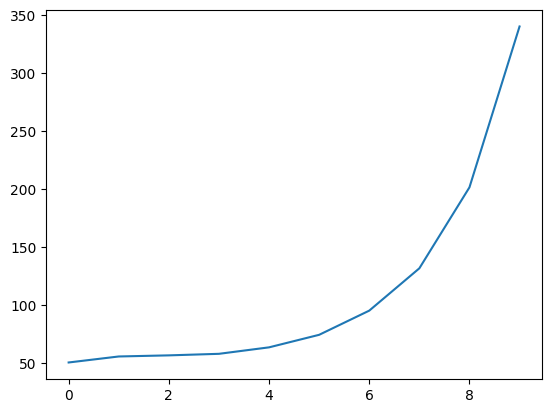

In [8]:
plt.plot(times)

In [6]:
print("HI")

HI


## MABrax Ant

In [9]:
""" 
Based on PureJaxRL Implementation of PPO

NOTE: currently implemented using the gymnax to smax wrapper
"""

import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
import smax
from smax.wrappers.smaxbaselines import LogWrapper
import matplotlib.pyplot as plt

class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        actor_logtstd = self.param('log_std', nn.initializers.zeros, (self.action_dim,))
        pi = distrax.MultivariateNormalDiag(actor_mean, jnp.exp(actor_logtstd))

        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)
    
class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray

def batchify(x: dict, agent_list, num_actors):
    x = jnp.stack([x[a] for a in agent_list])
    return x.reshape((num_actors, -1))

def unbatchify(x: jnp.ndarray, agent_list, num_envs, num_actors):
    x = x.reshape((num_actors, num_envs, -1))
    return {a: x[i] for i, a in enumerate(agent_list)}

def make_train(config):
    env = smax.make(config["ENV_NAME"], **config["ENV_KWARGS"])
    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ACTORS"]  # Q: NUM_ACTORS CORRECT?
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ACTORS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    
    #env = FlattenObservationWrapper(env) # NOTE need a batchify wrapper
    env = LogWrapper(env, replace_info=True)
    
    def linear_schedule(count):
        frac = 1.0 - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"])) / config["NUM_UPDATES"]
        return config["LR"] * frac

    def train(rng):

        # INIT NETWORK
        # TODO doesn't work for non-homogenous agents
        network = ActorCritic(env.action_space(env.agents[0]).shape[0], activation=config["ACTIVATION"])
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env.agents[0]).shape)
        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), optax.adam(config["LR"], eps=1e-5))

        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )
        
        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset)(reset_rng)



        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])
                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                
                pi, value = network.apply(train_state.params, obs_batch)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)
                env_act = unbatchify(action, env.agents, config["NUM_ENVS"], env.num_agents)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = jax.vmap(env.step)(
                    rng_step, env_state, env_act,
                )

                info = jax.tree_map(lambda x: x.reshape((config["NUM_ACTORS"])), info)
                transition = Transition(
                    batchify(done, env.agents, config["NUM_ACTORS"]).squeeze(),
                    action,
                    value,
                    batchify(reward, env.agents, config["NUM_ACTORS"]).squeeze(),
                    log_prob,
                    obs_batch,
                    info,
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )
            
            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            last_obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])
            _, last_val = network.apply(train_state.params, last_obs_batch)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=8,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)
            
            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ACTORS"]
                ), "batch size must be equal to number of steps * number of actors"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]
            
            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, metric = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )
        return {"runner_state": runner_state, "metrics": metric}

    return train

In [10]:
config = {
    "LR": 2.5e-4,
    "NUM_ENVS": 2048,
    "NUM_STEPS": 10,
    "TOTAL_TIMESTEPS": 2e7,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": 4,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.01,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "ENV_NAME": "ant_4x2", # Q: Do the versions correspond to internal or external?
    "ENV_KWARGS": {},
    "ANNEAL_LR": True,
}

rng = jax.random.PRNGKey(30)
train_jit = jax.jit(make_train(config))
out = train_jit(rng)

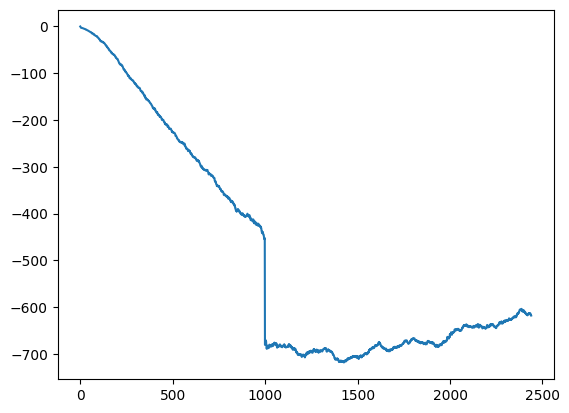

In [12]:
plt.plot(out['metrics']['returned_episode_returns'].mean(-1).reshape(-1))